In [9]:


import requests

from concurrent.futures import ThreadPoolExecutor

from pyquery import PyQuery as pq

import json

import threading


import time


def get_list_page_url(city):

    start_url = "https://{}.lianjia.com/ershoufang".format(city)
    headers =  {
        'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; WOW64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/69.0.3497.100 Safari/537.36',
    }
    try:
        response = requests.get(start_url, headers=headers)
        # print(response.status_code, response.text)
        doc = pq(response.text)
        total_num =  int(doc(".resultDes .total span").text())
        total_page = total_num // 30 + 1
        # 只能访问到前一百页
        if total_page > 200:
            total_page = 200

        page_url_list = list()

        for i in range(total_page):
            url = start_url + "/pg" + str(i + 1) + "/"
            page_url_list.append(url)
            #print(url)
        return page_url_list

    except:
        print("获取总套数出错,请确认起始URL是否正确")
        return None


detail_list = list()

# 需要先在本地开启代理池
# 代理池仓库: https://github.com/Python3WebSpider/ProxyPool
def get_valid_ip():
    url = "http://localhost:5000/get"
    try:
        ip = requests.get(url).text
        return ip
    except:
        print("请先运行代理池")


def get_detail_page_url(page_url):
    global detail_list
    headers =  {
        'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; WOW64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/69.0.3497.100 Safari/537.36',
        'Referer': 'https://bj.lianjia.com/ershoufang'
    }

    try:
        response = requests.get(page_url,headers=headers,timeout=3)
        doc = pq(response.text)
        # broswer.get(page_url)
        # print(page_url)
        # doc = pq(broswer.page_source)
        i = 0
        detail_urls = list()
        for item in doc(".sellListContent li").items():
            i += 1
            if i == 31:
                break
            child_item = item(".noresultRecommend")
            if child_item == None:
                i -= 1
            detail_url = child_item.attr("href")
            detail_urls.append(detail_url)
        return detail_urls
    except:
        print("获取列表页" + page_url + "出错")

lock = threading.Lock()

def detail_page_parser(res):
    global detail_list
    detail_urls = res.result()
    if not detail_urls:
        print("detail url 为空")
        return None
    headers =  {
        'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; WOW64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/69.0.3497.100 Safari/537.36',
        'Referer': 'https://bj.lianjia.com/ershoufang'
    }
    for detail_url in detail_urls:
        try:
            response = requests.get(url=detail_url, headers=headers,timeout=3)
            #print(response.status_code)
            detail_dict = dict()
            doc = pq(response.text)
            unit_price = doc(".unitPriceValue").text()
            unit_price = unit_price[0:unit_price.index("元")]
            title = doc("h1").text()
            area = doc(".areaName .info a").eq(0).text().strip()
            url = detail_url
            detail_dict["title"] = title
            detail_dict["area"] = area
            detail_dict["price"] = unit_price
            detail_dict["url"] = url

            detail_list.append(detail_dict)

            print(unit_price, title, area)

        except:
            print("获取详情页出错,换ip重试")
            proxies = {
                "http": "http://" + get_valid_ip(),
            }
            try:
                response = requests.get(url=detail_url, headers=headers, proxies=proxies)
                #print(response.status_code)
                detail_dict = dict()
                doc = pq(response.text)
                unit_price = doc(".unitPriceValue").text()
                unit_price = unit_price[0:unit_price.index("元")]
                title = doc("h1").text()
                area = doc(".areaName .info a").eq(0).text().strip()
                url = detail_url
                # 已下架的还会爬取，但是没有价格
                if len(unit_price)>0:
                    detail_dict["title"] = title
                    detail_dict["area"] = area
                    detail_dict["price"] = unit_price
                    detail_dict["url"] = url

                    detail_list.append(detail_dict)

                    print(unit_price, title, area)
            except:
                print("重试失败...")


def save_data(data,filename):
    with open(filename+".json", 'w', encoding="utf-8") as f:
        f.write(json.dumps(data, indent=2, ensure_ascii=False))
        print('hello')

def main():
    # cq,cs,nj,dl,wh,cc
    city_list = ['xa']
    for city in city_list:
        page_url_list = get_list_page_url(city)

        # pool = threadpool.ThreadPool(20)
        # requests = threadpool.makeRequests(page_and_detail_parser, page_url_list)
        # [pool.putRequest(req) for req in requests]
        # pool.wait()

        p = ThreadPoolExecutor(30)

        for page_url in page_url_list:
            p.submit(get_detail_page_url, page_url).add_done_callback(detail_page_parser)
        # 这里的回调函数拿到的是一个对象。
        # 先把返回的res得到一个结果。即在前面加上一个res.result(),这个结果就是get_detail_page_url的返回
        p.shutdown()

        print(detail_list)

        save_data(detail_list, city)

        detail_list.clear()

if __name__ == '__main__':
    old = time.time()
    main()
    new  = time.time()
    delta_time = new - old
    print("程序共运行{}s".format(delta_time))










13287 二环里，城墙角，交通便利，业主靠谱，期待有缘人！ 莲湖
10237 业主诚心出售，精装两室，未住过人，随时看房 高陵
9098 纺织城双地铁，交通便利户型方正，楼层好，精装2居室 灞桥
10000 真正河景房!采光超好，风景如画 ！中高楼层！ 高陵
13510 8号线地铁 楼层好 三室精装修 可按揭 灞桥
11712 产证在手，随时交易，业主诚心出售 雁塔
15691 高新区 大寨路 通透三居 中高楼层 采光视野无遮挡 雁塔
16585 大平层，证在手，产权清晰，诚心出售，随时可看，两厨 雁塔
14965 地铁口 凤城三路 香克林小镇 两室 证在手 未央
13415 精装两室两厅，交通便利，配套成熟 莲湖
12991 长安相府125平宽敞3室拎包入住！ 长安
21650 金辉公园里 3室2厅 南 北 雁塔
17000 满三满二 不临街小高层 南北通透 毛坯大三居 雁塔
18994 航天城，地铁口，精装三室，电梯房，业主诚心出售 长安
9009 泾河工业园水榭花都精装两室，拎包入住 高陵
20637 大学城商圈 高新隔壁 雅居乐铂琅峯 精装三室 采光好 长安
20701 地铁口.大开发商，适合刚需的全明户型 雁塔
23965 曲江二期，品质小区精装修，视野好无遮挡人车分流 雁塔
10599 大明宫国家遗址公园旁，南北三居室，单价10500 未央
10274 房源优质，户型方正，8号线双地铁口800米 莲湖
9829 证在手 可按揭 诚心出售 楼层美丽 莲湖
10098 楼层好 户型方正 诚心出售 位置好 雁塔
20900 高新区 地铁口 品 质新小区满三满二 诚心出售 雁塔
9940 全明格局，温泉洗浴 地暖，有停车位一年管理费900+ 雁塔
8681 大三室 高层双气 市政供暖 朝南 产证在手 随时看房 新城区
19055 北大街 五路口 钟楼 育英 后宰门 地铁口 自采暖 新城区
15967 华润两室中的大户型，面积大，楼层高，视野采光好。 未央
12386 旗远锦樾 高新繁华地段 50年办公产权 雁塔
8736 留园森林别墅、、南北通透、低价出售 未央
7187 经典户型，采光极好业主诚心出售。 高陵
21461 经典户型，公摊小得房率高，证在手有钥匙，免增值税 雁塔
29073 中海凯旋门经典大三居室 南北通透 业主诚意出售 雁塔
15466 此房

19874 自然界新小区超大楼距，人车分流，电梯入户 未央
20686 此房采光无遮挡，楼层好，全明户型，地铁6号线， 雁塔
17498 唐延路延平门地铁口 低密社区三室户型诚心出售带车位 雁塔
22031 南湖边，紫薇意境，楼间距大，采光好 雁塔
26468 紫薇田园都市A区 双ZHI标 精装满二急售 长安
12106 晟方佳苑98平小三室 西南朝向 业主诚心出售 雁塔
19908 金辉地产 方正两居 全明格局 精装修 拎包入住 雁塔
12728 盛龙广场太白苑 3室1厅 东南 碑林
18786 万科金色悦城优质2居 满三满二，精装修 急售！！ 莲湖
16582 业主诚信出售 随时签约 产权清晰 莲湖
11266 急售急售！八水洋房南北通透诚心出售！ 莲湖
17677 大明宫遗址公园旁 地铁口旁 户型方正采光好 未央
18042 御锦城九龙湾 精装修婚房满三满二 灞桥
30699 水晶城、双指标、诚心出售、钥匙在手、指标靠谱 雁塔
13278 浐河地铁口 水岸东方1期 2室全明户型出售 满三满二 灞桥
17254 满三满二 钥匙在店 看房随时 业主诚心出售 灞桥
14522 浐河西岸 暖山西安 精装两居 偏门通透双阳台 满三满二 雁塔
9944 此房楼层好、视野宽阔、采光充足、配套设施齐全 莲湖
19957 精装修，配套齐全，日常出行方便！ 雁塔
21795 地铁口 保利心语花园 纯正7+1洋房 满三满二 超大空间 未央
26053 北池头地铁口 优质两居室 满三满二 雁塔
11272 莲湖区 花园洋房 蔚蓝花城南北双露台 可按揭随时可看 莲湖
11495 满三满二，精装全配出售，可拎包入住 长安
15691 高新区 大寨路 通透三居 中高楼层 采光视野无遮挡 雁塔
17707 指标在可承诺 着急出手价格可谈 看房方便 联系维护人 雁塔
20846 金地二期精装两室，中高楼层，采光好！东户 雁塔
14433 纯南户，采光好 不临街 全明户型，配套齐全 未央
10834 西北建材 2室0厅 南 碑林
12670 枣园地铁口 纯南两居室 业主诚意出售 莲湖
12534 市图书馆地铁口赛高国际 满三满二 诚心出售 未央
13275 水岸东方 地铁口 一梯两户 南北三室 满三满二 灞桥
14128 北二环地铁口精装修，业主诚心出售。 未央
10149 五环节约坊 两室精装

13471 学林雅苑 2室2厅 南 长安
12332 满五唯一，税费少，业主诚心出售，出行方便。 莲湖
16563 ，枫叶新都市 有指标 临地铁 诚心出售 雁塔
13784 劳动路园林社区 刚需两室 全明户型 莲湖
12895 樱花广场，纯南户型，满三满二，业主诚心出售， 长安
26166 经典3居室精装修，近地铁，南北透通，满3满2产权清晰 雁塔
10179 地铁口两室，产证在手满三满二，配套完善 未央
14521 简装大两居，简装提前预约随时可看 雁塔
13984 韦曲南地铁口三室纯南户型，业主诚心出售 长安
10365 二环内大明宫遗址公园旁 一梯两户 南北通透 满三满二 未央
28834 枫林意树，精装一室，有zhi标，看房方便。 雁塔
14660 大明宫旁 大两居 纯南户型 2梯3 视野开阔 未央
17932 次新小区，此房满三满二精装大四室未入住.小区正中 雁塔
12713 公园南路旁园林式小区天然居二期大三室业主诚意出售 雁塔
18750 高新品阁 太白南路地铁口 精装修 复室 雁塔
12103 会展地铁口 精装修 随时看房 雁塔
13840 此房纯南朝向，采光良好，业主诚心出售 长安
25248 哇塞好房 房子满三满二 随时看房 精装婚房 12年一站式 未央
15666 北二环公园壹品 4室南北通透 精装出售。 未央
16618 魏玛公馆优质正规一室一厅诚心出售 未央
12090 业主诚心出售，房子产权清晰，房子精装修，全明户型 未央
12200 雅苑东方 一室一厅 朝南 毛坯房 价格可谈 新城区
16447 东三环雁鸣湖合能一期 精装修未入住 价位可谈满三满二 灞桥
21036 G户型，中间楼层，基本全新，双指标，诚心出售 长安
14712 凤城八路，大融城旁，EE康城东区，两居室有钥匙随时看 未央
6883 品质小区 地理位置优越 繁华地段 出行方便 集中供暖 高陵
25107 满三满二 闹中取静 中高无遮挡 视野开阔 雁塔
35065 中海东郡 精装两室 不临街 小高层 红本在手 诚心卖 雁塔
12522 业主诚心卖，房子满三满二。看房方便 灞桥
9300 十号线地铁站 单价每平9300 精装 现房 高陵
15098 朝南户型，采光充足，视野宽阔，配套齐全，业主急售。 莲湖
23542 地铁口+精装修+满三满二+带指标+小区中间+诚心出售 雁塔

24430 急急急，可大刀，云顶园，满三满二，业主诚心出售。 雁塔
20334 龙湖花千树 精装两室 地铁口 看房方便 长安
34142 产权清晰，纯南，阳光充足前后无遮挡，双指标 雁塔
12375 凤城十路 精装婚房 南北通透 满3满2 西航四校 未央
17141 经开区 地铁口 纯南 小两室 代经开二 未央
12851 旭景碧泽园精装大两居 户型采光好 雁塔
11920 区政府旁 两居室 满三满二 诚心出售 长安
11484 此房中高楼层 视野采光好 房子满二 业主靠谱出售 雁塔
18404 城市花园，中间楼层，南北通透，采光好，视野开阔， 雁塔
13637 三居室 大阳台 视野好 精装修，满三满 雁塔
16433 地铁口小两居 全明户型 业主诚心出售 雁塔
20701 地铁口.大开发商，适合刚需的全明户型 雁塔
14151 盛世长安 满三满二 业主诚心出售 长安
9111 文景路 青门新区 业主急售 未央
24408 绿地世纪城，大一室，精装修带指标，诚心出售 雁塔
12749 满三满二，地铁口，纯南两居，采光视野好，看房方便 灞桥
13238 此房标准两室一厅 光线好 视线好 雁塔
15199 紫郡长安，户型方正，南北通透，看房方便 雁塔
15974 此房满3满2、18年新装修、小区距地铁口。 雁塔
22706 大寨路毛坯4居 南北通透 花园洋房 一梯两户 有钥匙 雁塔
15126 满3满2 视野开阔 产权清晰 采光好 雁塔
16823 满三满二，楼层好，业主诚心出售 长安
10387 业主诚心出售 房子满3满2，产证在手，交易无忧！ 未央
22476 直观小区花园 满二没有增值税 不临街 业主诚心 随时看 雁塔
21353 满五满二，南北通透，单指标，不临街 雁塔
17749 户型方正 卫浴全明 主卧、次卧朝南 无遮挡采光 长安
23788 缤纷南郡带露台纯南两居室，满三满二 雁塔
18768 此房经典3室，南北朝向，采光视野很好，高楼层 雁塔
15008 华城泊郡新上一室 东向 满三满二 税费少诚心出售 雁塔
12404 丰盛园 2室2厅 南 北 莲湖
14946 延兴门地铁口 标准一室精装朝南 产证在手 新城区
15196 科技路西口，枫韵蓝湾，园林社区，两室纯朝南，自住房 雁塔
14841 未央区 阳光台365 3室2厅2卫 全明 精装修 未央
16

24985 万科金典四居 楼层低不吵 户型方正 雁塔
12956 房间内精装修，房间保持良好，配置齐全 未央
9217 电子城一室单间，诚心出售，单身优选 雁塔
13540 上东大道 2室2厅 西南 未央
14091 房子是毛坯的，无限创意发挥，自由装修 灞桥
18542 锦业路 地铁口 华为旁边 毛坯大三室 雁塔
15487 卡布奇诺国际社区 ，此房中等楼层，视野开阔，精装修 长安
14167 小寨朱雀大街皇 家公馆三室一厅业主诚心出售看房方便 雁塔
16035 御锦城云禧，大三室，业主诚心出售 灞桥
13033 经开区地铁口纯南大两室 地铁口 未央
13160 会展D铁口+象牙宫寓+精装修+拎包入住+业主靠谱 雁塔
15228 浐灞半岛 精装三居 全明三居 满三满二满五唯一 灞桥
18523 曲江 地铁 曲江城市花园 一期 不临街 精装两居室 雁塔
15742 满三满二 精装修 刚需两室 诚心出售 未央
15463 交大精装修一室房源，看房方便业主诚心出售，预售从速 碑林
13328 满三满二，大开发商精装修交付，采光充足。 未央
14570 经开区 凤城九路 两室精装 纯南朝向 采光通风好 未央
14618 东二环 双地铁口 平层一室 户型方正 采光好 灞桥
20890 急售 全明小三室 带全屋家具家电 拎包入住 雁塔
16690 超大楼间距 采光视野好 东门出去便是曲江四小 雁塔
9103 产权清晰 满五唯一 南北朝向 双卧大阳台 长安
11328 三环内 4号线地铁口 大两室毛坯 可按揭 未央
15438 大兴新区天朗大兴郡悦城三室好房业主诚心出售 莲湖
16250 高新区 东尚蜂鸟 48平一室业主诚心出售 产证在手 长安
19175 双地铁 华洲城熙悦都 精装两室 业主诚意出售 未央
16565 房子满三满二。产权清晰，诚心卖，价位可谈 灞桥
16894 满三满二，产权清晰，业主诚心出售 雁塔
14763 富力白鹭湾三居室 南北通透 精装修 满三满二 靠谱出售 灞桥
14464 户型方正，二环内，满三满二，品质小区 未央
11767 中间楼层 采光视野好 业主诚意出售 莲湖
11837 地铁8号线，小区中间位置，采光好，通风好 未央
14610 荣民宫园 二环内新小区 大明宫公园旁 未央
18576 尚品美的城小三居诚心出售，近华为，近地铁 雁塔
931

17250 次新楼盘，南北通透，精装两室，诚心出售，看房方便 雁塔
13543 地铁五号线！精装两室!诚心出售！ 莲湖
15659 四号线 余家寨 大明宫万达 诚心出售 未央
17238 洋房社区 双地铁 满三满二 诚心出售 未央
12875 檀香园，全南两室，精装修，房本在手，可按揭 灞桥
15064 绿化高 品质小区 央企开发商 户型好看房方便 未央
11649 公园旁地铁边医院在隔壁，如此优秀何愁不卖 碑林
15873 凤城九路，文景路魏玛公馆 标准一室，满三满二。 未央
17049 十八街坊 中间楼层 满三满二 随时交易 莲湖
10099 凤城三路 近地铁交通便利 满三满2 单价1万 未央
8634 大两室，成熟生活配套，出行方便 新城区
12817 大学城商圈区政府配套 精装修 没住过人 带电梯三居室 长安
21822 万科幸福系 采光好 精装修 拎包入住 一梯两户 莲湖
16637 合能公馆带装修带家电高品味生活从这里开始！随时看房 长安
17720 枫林九溪竹韵 3室2厅 南 北 灞桥
10160 柿园路 东方星座 兴庆公园北门 经九路 碑林
12500 海璟时代 3室1厅 南 西 北 未央
11188 小区环境优雅舒适 交通便利近地铁 生活便利 未央
9815 西稍门好地段，开元商场楼上，双阳台、明厨明卫！ 莲湖
18866 纯南朝向 三室两厅两卫 客厅带阳台 全明户型 精装修 未央
11932 铁建水岸雅苑 二居房 业主诚心出售 小区环境好 灞桥
11628 紫昕花庭 胡家庙十字 拎包入住 交通便利 新城区
13201 标准一室一厅，产权清晰，随时可看房 未央
9159 新城悦隽公园里 3室2厅 南 北 高陵
16530 高新六路 核 心地段 精装两居室 雁塔
13701 近地铁 精装两室 南北通透 交通便利 配套齐全 新城区
13035 辛家庙地铁口，南北通透厅带阳台，中高楼层 诚心出售 未央
11945 精装出售，外带50平露台。业主诚心出售！ 灞桥
12706 优质三室户型，产权清晰，单价低于小区成交均价 未央
14103 安远门地铁口 纯南两室 诚心出售 莲湖
17679 绿地曲江名城 户型方正业主诚心出售 雁塔
13384 （急售）曲江二期，地铁口满二税费少， 长安
18015 满三满二，精装修，地铁口，配套齐全，业主诚心出售。 长安
1

13536 精装一室 纯南户型 满三满二 雁塔
15654 不临三环 地铁口 曲江明珠 业主诚心出售 随时看房 满2 雁塔
15468 汉城南路 地铁口 不临街 精装两居 业主诚心出售 莲湖
12990 地铁口，一室开间，优质房源，看房方便 雁塔
17714 东方罗马花园，两室两厅，纯南户型，看房方便 灞桥
13258 90平大两室，朝南，楼层佳采光好，精装修家具家电齐全 莲湖
13070 对望高新管委会，三室精装修，业主急售，看房方便 雁塔
9292 中南春溪集 3室2厅 南 北 高陵
8774 采光好 交通便利 毛坯三室可自行设计装修 高陵
20878 金乎沱地铁口一金辉世界城一不临三环，小三室户型 雁塔
19915 二环边，双地铁，精装复式，业主自住，诚心出售 灞桥
13863 唐韵三坊 东二环 胡家庙旁 精准全明两室 拎包入住 新城区
10371 精装修 大两室 把边户型全明 户型通透 可拎包入住 高陵
18605 中楼层，全明户型，满五 诚心出售 雁塔
14061 灞业大境 4室2厅 南 北 灞桥
23015 满二过户，诚心出售，随时看房。 雁塔
11264 满三满二 视野开阔 出行方便 采光良好 业主诚心出售 莲湖
14592 辛家庙地铁口 精装两室 诚心出售商圈成熟 未央
16702 近地铁，一级物业，品质小区，房子南北通透，中间楼层 未央
11797 此房产权清晰，70年产权住宅，配套成熟，交通便利 雁塔
17573 雁塔区 高新国际學校旁 温馨小两室 满2 安静舒适 雁塔
14877 高品质社区，户型方正，无浪费面积，满三满二 灞桥
9589 龙首原地铁口户型好采光无遮挡有证可按揭随时过户 莲湖
20479 精装自住，家具家电全带，近地铁近公园，一级物业 雁塔
10714 小区近地铁，小区环境优雅，安静明亮， 灞桥
11943 楼层接地气，采光充足，配套设施齐全，交通便. 新城区
15141 业主诚心出售 看房提前约 业主过来开门 未央
16095 航天城毛坯现房两室 纯南户型 满三满二 长安
11538 凤城五路 文景路 海璟时代 业主急售 未央
12016 图书馆地铁口 精装两居室 满三满二 诚心出售 未央
8646 此房满三满二 南北通透格局 户型方正 灞桥
11558 业主称心出售！看房随时可以看！价格还可以谈！ 灞桥
21845 大力推荐

22087 鱼化寨 地铁口 满三满二，精装修，业主诚售 雁塔
8870 纺织城地铁口+唐都医院+5室2厅2卫+大平层 灞桥
18935 金业缇香山 西影路 公园南路 业主诚心出售 雁塔
14638 地铁口，三室精装全配，拎包入住， 灞桥
12823 满三满二，可按揭 ，毛坯房可自由装修， 未央
10123 南北通透，三面朝南，采光别提多棒了，地铁口 长安
18713 延平门地铁口 高新商圈 1T2户小高层 雁塔
9241 地铁口 精装修两室品牌家具家电全带 产权清晰 可按揭 高陵
37871 高新紫薇公园时光精装三室满三满二诚心出售 雁塔
14732 公园复式买一层带一层169.7+110带2花园露台 新城区
36540 中海紫御华府 满三满二 证在手 业主诚心出售 雁塔
12585 好房子不是用来欣赏的，是用来享受的 未央
17390 万科开发 精装两室 户型方正无浪费 未央
9445 地铁口 一线湖景 户型方正 采光极好 高陵
26749 高新大寨路品质小区 毛坯四室 诚心出售 满三满二 雁塔
6323 车城花园 少有毛坯房 业主急售 看房方便 高陵
13614 东南小三室106平，百米楼间距，业主自住房看房有钥匙 雁塔
19839 满三满二 地铁口 南北通透 雁塔区 看房方便 雁塔
17606 北二环 精装 四室 南北朝向 采光好 业主诚心出售 未央
10777 纯南朝向，一梯两户，满三满二，楼层光照佳，桃花潭旁 灞桥
17789 桃花潭公园地铁边，满三满二精装修，业主诚心出售 灞桥
12675 此房满三满二，户型好，楼层好，视野宽阔，采光充足 未央
10457 华美小区 3室1厅 南 北 长安
22248 万科经典F三居室 南北通透 双指标 长安
14252 桃花潭地铁口 毛坯房可装修 环境优美 灞桥
15823 精装两室，南北通透，满三满二，环境优美，交通便利 灞桥
10433 长安广场3室房 南北通透 有房产证 看房有钥匙 等你来 长安
14123 朝西精装好房 高楼层 采光一级棒 业主诚意出售 未央
7358 白桦林家愿 四室两厅 毛坯房 看房方便 高陵
15000 华城国际精装自住房 满三满二 明厨明卫 诚心出售 雁塔
13578 此房视野宽阔，采光充足，小区绿化高，品质小区 未央
28304 精装洋房，中间楼层，采光好通透性好，电梯入户！！！ 雁塔

15835 南北通透大四室，楼层好，采光无遮挡 灞桥
17494 浐灞1号 134平三室 满三满二 精装修 诚心出售 无尾款 未央
24995 曲江二期洋房顶复，四房四卫，诚意出售证手过二 雁塔
11744 满三满二 小三室 小区没有物业费以及停车费 未央
14419 南向大两房 采光视野俱佳 不满二 未央
12152 欣心家园 3室2厅 南 西南 未央
12112 东二环 通化门 东窑坊 两室朝南 全明户型 碑林
7938 泾渭国际城 三室 全明户型 户型方正 满二 高陵
10192 电炉所家属院，交大一附院旁边，适合居住，交通便利 雁塔
14102 凤栖原地铁口C口400米左右交通便利 长安
20294 低密洋房社区，临河，户型正气，一梯两户，有钥匙 灞桥
15461 品质小区 精装南北大三室 自住房 过二 有证 雁塔
25383 保利拉菲公馆南区唯一，小高层出售，满三满二 未央
14321 东南城角 郦景豪庭 2室 全明户型 业主诚心出售 碑林
6504 华清泉庄园 4室2厅 南 北 临潼
17128 天朗蔚蓝君城全明两居、满三满二，婚房精装，采光充足 莲湖
18896 业主诚心出售 看房提前联系 俯视大唐西市 莲湖
17621 此房是大华公园世家一期底跃花园洋房，南北通透 雁塔
11580 配套设施齐全交通便利通风采光良好满三满二产证在手 未央
18540 蓝湖树优质房源，中间楼层，户型优质 雁塔
13537 业主诚心出售，房子保持好，可拎包入住。 灞桥
15771 桃花潭公园地铁边，满五唯一精装修，业主诚心出售 灞桥
14846 地铁口，小俩室，精装修，拎包入住 未央
31015 一楼底跃带花园，南湖边，地铁口，简装，随时看房 雁塔
28304 精装洋房，中间楼层，采光好通透性好，电梯入户！！！ 雁塔
23667 紫薇永和坊 5室3厅 南 北 雁塔
10298 开元高科新村 3室2厅 南 北 新城区
15468 富力白鹭湾 4室2厅 南 北 灞桥
20727 万科精装修，大三室，经典户型，业主诚心出售 未央
11400 产权清晰满三满二70年住宅交通便利 新城区
11347 雅荷智能家园 4室2厅 南 北 未央
27884 紫薇田园都市K区 精装修复式洋房 产证在手 随时过户 长安
11827 汉城湖畔，顶层带阁楼，满三满二无增值税，配套齐全 未央
200

15026 采光充足产证在手诚心出售满三满二 未央
8996 群贤北府优质房源大三室户型方正采光好，业主诚心出售 高陵
12930 东二环地铁口顶楼复式带楼台满三满二 碑林
13231 龙首原地铁口 精装阔绰两室 南北通透 自住婚房 未央
11549 房子发展空间大，户型好，板正三室 长安
13737 户型方正,南北通透,诚心出售房屋 未央
13353 昆明路 全明三房 满二满三 地 铁 高楼层 价格美丽 莲湖
18913 稀有航天城，一楼带花园，业主诚售，满三，看房方便 长安
18908 三号线旁 南北通透两室 一梯两户 中间楼层 采光充足 雁塔
7769 此房满五不唯一，房本在手 南北朝向 好楼层 采光好 高陵
13340 丰盛园两室，南北户型，低楼层，配套齐全 莲湖
11435 公园大观 3室1厅 南 莲湖
8870 纺织城地铁口+唐都医院+5室2厅2卫+大平层 灞桥
19236 锦业路地铁口罗马景福城精装一室 雁塔
8161 超市旁 八水御源 精装两室 全明户型 证在手 高陵
20225 满三满二精装修婚房，全屋定制家居，大品牌开发商 未央
17092 4室跃层，南北朝向户型好，采光好， 满三满二 长安
13621 汉城湖畔精装 南北通采光好 商圈成熟拎包入住 未央
18586 莱安逸珲 品质小区 精装自住两居室 雁塔
29870 曲江印正北，70年满五大平层，中高楼层，全明格局。 雁塔
31151 此房满三满二，南北朝向通风好格局好， 顶跃 未央
11865 北郊地税局177平单价11000 带双气 未央
12547 枣园地铁口 交通便利 采光好 业主诚心出售 莲湖
23858 南北通明厨明，100米楼间距，无遮挡视野好 雁塔
20450 公园华府万科一级物业精装三室南北通透新房未住人 雁塔
20232 北二环大明宫锦园新世纪全明四居室南北通透 未央
20355 此房南北通透， 布局合理出行方便 ，装修很好，证在手 未央
15359 中铁琉森水岸 3室2厅 南 北 灞桥
12150 户型好 南北通透 满五满二 视野好 采光足 雁塔
17739 国色天香一期洋房 满三满二 业主诚心出售 长安
9484 南二环西延铁路3室精装证在手可按揭贷款 雁塔
7711 店子王生态家园 3室2厅 南 北 高陵
13181 此房满三满二，南北通透.楼层比较好 雁塔
1584

24166 小区中间 高楼层 好视野 50万精装修 诚心出售 长安
11818 长安广场旁 房管新村 业主诚心出售 看房方便 长安
10237 业主诚心出售，精装两室，未住过人，随时看房 高陵
10237 业主诚心出售，精装两室，未住过人，随时看房 高陵
10237 业主诚心出售，精装两室，未住过人，随时看房 高陵
9727 锦业路纯南两室公寓，通双气 投 资自住均可 雁塔
10237 业主诚心出售，精装两室，未住过人，随时看房 高陵
10237 业主诚心出售，精装两室，未住过人，随时看房 高陵
10237 业主诚心出售，精装两室，未住过人，随时看房 高陵
9290 市图书馆地铁口 雅荷花园 226平大平层 大型社区 未央
19099 万达公馆五室两厅满三满二南北户型中间楼层看房方便 未央
14609 精装纯南两室，高绿化品质小区，业主急售 莲湖
10237 业主诚心出售，精装两室，未住过人，随时看房 高陵
9185 高陵区马家湾 品质小区水半湾 三室好户型 高陵
21457 户型方正 南北通透 诚心出售 精装保持好 长安
10237 业主诚心出售，精装两室，未住过人，随时看房 高陵
19099 万达公馆五室两厅满三满二南北户型中间楼层看房方便 未央
19099 万达公馆五室两厅满三满二南北户型中间楼层看房方便 未央
19099 万达公馆五室两厅满三满二南北户型中间楼层看房方便 未央
19099 万达公馆五室两厅满三满二南北户型中间楼层看房方便 未央
19099 万达公馆五室两厅满三满二南北户型中间楼层看房方便 未央
21856 辛家庙，广泰门，海蓝城小区，顶层复式 未央
13825 4居南北户型，户型方正，交通便利，近临上学 灞桥
25822 曲江中海碧林湾，三室两厅两卫，两梯三户 雁塔
19099 万达公馆五室两厅满三满二南北户型中间楼层看房方便 未央
19006 富力城北区精装四室，南北通透，诚心出售 长安
37028 绿洲顶复不临街双指标，诚心出售,HAO华装修 雁塔
19099 万达公馆五室两厅满三满二南北户型中间楼层看房方便 未央
19117 精装修品牌家具家电 满三满二 随时看房 灞桥
11972 图书馆地铁口 精装3室 大明宫畔 诚信出售 未央
12088 满三满二 格局好交通便利 近地铁 新城区
10237 业主诚心出售，精装两室，未住过人，随时看

exception calling callback for <Future at 0x7fbe4420db50 state=finished returned list>
Traceback (most recent call last):
  File "<ipython-input-9-344eb54b0609>", line 99, in detail_page_parser
    response = requests.get(url=detail_url, headers=headers,timeout=3)
  File "/home/yangjihao/anaconda3/lib/python3.8/site-packages/requests/api.py", line 76, in get
    return request('get', url, params=params, **kwargs)
  File "/home/yangjihao/anaconda3/lib/python3.8/site-packages/requests/api.py", line 61, in request
    return session.request(method=method, url=url, **kwargs)
  File "/home/yangjihao/anaconda3/lib/python3.8/site-packages/requests/sessions.py", line 516, in request
    prep = self.prepare_request(req)
  File "/home/yangjihao/anaconda3/lib/python3.8/site-packages/requests/sessions.py", line 449, in prepare_request
    p.prepare(
  File "/home/yangjihao/anaconda3/lib/python3.8/site-packages/requests/models.py", line 314, in prepare
    self.prepare_url(url, params)
  File "/hom

21461 经典户型，公摊小得房率高，证在手有钥匙，免增值税 雁塔
19099 万达公馆五室两厅满三满二南北户型中间楼层看房方便 未央
19099 万达公馆五室两厅满三满二南北户型中间楼层看房方便 未央
19099 万达公馆五室两厅满三满二南北户型中间楼层看房方便 未央
15693 盛世长安刚需朝南两室，业主诚心出售。 长安
15642 产权清晰 满三满二 户型方正 中高楼层 未央
18436 北苑地铁口，精装修大两室纯南业主诚心出售. 未央
15642 产权清晰 满三满二 户型方正 中高楼层 未央
20008 中海开元壹号二期经典三居两卫户型南北通透看房方便 未央
16813 世园大公馆顶楼大户型，采光视野很好，业主诚心出售 灞桥
11720 满三满二，中间楼层，不临街产权清晰，业主诚心出售 未央
25156 曲江一期，刚需两居室，交通便利，景区也近。 雁塔
10330 满三满二，诚心出售，看房方便， 莲湖
获取详情页出错,换ip重试
请先运行代理池


exception calling callback for <Future at 0x7fbe4420df10 state=finished returned list>
Traceback (most recent call last):
  File "<ipython-input-9-344eb54b0609>", line 99, in detail_page_parser
    response = requests.get(url=detail_url, headers=headers,timeout=3)
  File "/home/yangjihao/anaconda3/lib/python3.8/site-packages/requests/api.py", line 76, in get
    return request('get', url, params=params, **kwargs)
  File "/home/yangjihao/anaconda3/lib/python3.8/site-packages/requests/api.py", line 61, in request
    return session.request(method=method, url=url, **kwargs)
  File "/home/yangjihao/anaconda3/lib/python3.8/site-packages/requests/sessions.py", line 516, in request
    prep = self.prepare_request(req)
  File "/home/yangjihao/anaconda3/lib/python3.8/site-packages/requests/sessions.py", line 449, in prepare_request
    p.prepare(
  File "/home/yangjihao/anaconda3/lib/python3.8/site-packages/requests/models.py", line 314, in prepare
    self.prepare_url(url, params)
  File "/hom

exception calling callback for <Future at 0x7fbe4420d970 state=finished returned list>
Traceback (most recent call last):
  File "<ipython-input-9-344eb54b0609>", line 99, in detail_page_parser
    response = requests.get(url=detail_url, headers=headers,timeout=3)
  File "/home/yangjihao/anaconda3/lib/python3.8/site-packages/requests/api.py", line 76, in get
    return request('get', url, params=params, **kwargs)
  File "/home/yangjihao/anaconda3/lib/python3.8/site-packages/requests/api.py", line 61, in request
    return session.request(method=method, url=url, **kwargs)
  File "/home/yangjihao/anaconda3/lib/python3.8/site-packages/requests/sessions.py", line 516, in request
    prep = self.prepare_request(req)
  File "/home/yangjihao/anaconda3/lib/python3.8/site-packages/requests/sessions.py", line 449, in prepare_request
    p.prepare(
  File "/home/yangjihao/anaconda3/lib/python3.8/site-packages/requests/models.py", line 314, in prepare
    self.prepare_url(url, params)
  File "/hom

10330 满三满二，诚心出售，看房方便， 莲湖
获取详情页出错,换ip重试
请先运行代理池
21461 经典户型，公摊小得房率高，证在手有钥匙，免增值税 雁塔
10330 满三满二，诚心出售，看房方便， 莲湖
获取详情页出错,换ip重试
请先运行代理池
10330 满三满二，诚心出售，看房方便， 莲湖
获取详情页出错,换ip重试
请先运行代理池
10330 满三满二，诚心出售，看房方便， 莲湖
获取详情页出错,换ip重试
请先运行代理池
10330 满三满二，诚心出售，看房方便， 莲湖
获取详情页出错,换ip重试
请先运行代理池
15642 产权清晰 满三满二 户型方正 中高楼层 未央
10330 满三满二，诚心出售，看房方便， 莲湖
获取详情页出错,换ip重试
请先运行代理池
24197 大华三期不临街精装洋房 四室两厅两卫 车位另算 雁塔
10330 满三满二，诚心出售，看房方便， 莲湖
获取详情页出错,换ip重试
请先运行代理池


exception calling callback for <Future at 0x7fbe4420de20 state=finished returned list>
Traceback (most recent call last):
  File "<ipython-input-9-344eb54b0609>", line 99, in detail_page_parser
    response = requests.get(url=detail_url, headers=headers,timeout=3)
  File "/home/yangjihao/anaconda3/lib/python3.8/site-packages/requests/api.py", line 76, in get
    return request('get', url, params=params, **kwargs)
  File "/home/yangjihao/anaconda3/lib/python3.8/site-packages/requests/api.py", line 61, in request
    return session.request(method=method, url=url, **kwargs)
  File "/home/yangjihao/anaconda3/lib/python3.8/site-packages/requests/sessions.py", line 516, in request
    prep = self.prepare_request(req)
  File "/home/yangjihao/anaconda3/lib/python3.8/site-packages/requests/sessions.py", line 449, in prepare_request
    p.prepare(
  File "/home/yangjihao/anaconda3/lib/python3.8/site-packages/requests/models.py", line 314, in prepare
    self.prepare_url(url, params)
  File "/hom

15642 产权清晰 满三满二 户型方正 中高楼层 未央
10330 满三满二，诚心出售，看房方便， 莲湖
获取详情页出错,换ip重试
请先运行代理池
10330 满三满二，诚心出售，看房方便， 莲湖
获取详情页出错,换ip重试
请先运行代理池
10330 满三满二，诚心出售，看房方便， 莲湖
获取详情页出错,换ip重试
请先运行代理池
17878 地铁口400米 中天雅苑 满三满二 南北通透 集中地暖 莲湖
21461 经典户型，公摊小得房率高，证在手有钥匙，免增值税 雁塔
21461 经典户型，公摊小得房率高，证在手有钥匙，免增值税 雁塔
10330 满三满二，诚心出售，看房方便， 莲湖
获取详情页出错,换ip重试
请先运行代理池
25168 紫楹台 3室3厅 东 南 北 灞桥
15642 产权清晰 满三满二 户型方正 中高楼层 未央
11778 万科棉花公寓 1室1厅 东 长安
13970 繁华地段大两室，南北通透。诚心出售。 长安
15642 产权清晰 满三满二 户型方正 中高楼层 未央
21583 黄雁村地铁口华豪丽晶 南北通透精装两室 性价高诚心卖 碑林
21461 经典户型，公摊小得房率高，证在手有钥匙，免增值税 雁塔
15642 产权清晰 满三满二 户型方正 中高楼层 未央


exception calling callback for <Future at 0x7fbe442135e0 state=finished returned list>
Traceback (most recent call last):
  File "<ipython-input-9-344eb54b0609>", line 99, in detail_page_parser
    response = requests.get(url=detail_url, headers=headers,timeout=3)
  File "/home/yangjihao/anaconda3/lib/python3.8/site-packages/requests/api.py", line 76, in get
    return request('get', url, params=params, **kwargs)
  File "/home/yangjihao/anaconda3/lib/python3.8/site-packages/requests/api.py", line 61, in request
    return session.request(method=method, url=url, **kwargs)
  File "/home/yangjihao/anaconda3/lib/python3.8/site-packages/requests/sessions.py", line 516, in request
    prep = self.prepare_request(req)
  File "/home/yangjihao/anaconda3/lib/python3.8/site-packages/requests/sessions.py", line 449, in prepare_request
    p.prepare(
  File "/home/yangjihao/anaconda3/lib/python3.8/site-packages/requests/models.py", line 314, in prepare
    self.prepare_url(url, params)
  File "/hom

10330 满三满二，诚心出售，看房方便， 莲湖
获取详情页出错,换ip重试
请先运行代理池
10237 业主诚心出售，精装两室，未住过人，随时看房 高陵
12812 丈八北路地铁口两居室 产证满两年 随时可看房 雁塔
15642 产权清晰 满三满二 户型方正 中高楼层 未央
27621 满三满二，房子带指标，户型好，视野好，业主诚心出售 雁塔
10248 霁虹苑小区 精装三室 满五唯一 证在手 莲湖
10330 满三满二，诚心出售，看房方便， 莲湖
获取详情页出错,换ip重试
请先运行代理池
12909 房子全明通透满五满二，小区园林湖泊风格，业主诚售 莲湖
10330 满三满二，诚心出售，看房方便， 莲湖
获取详情页出错,换ip重试
请先运行代理池
10330 满三满二，诚心出售，看房方便， 莲湖
获取详情页出错,换ip重试
请先运行代理池
14935 紫薇尚层 3室2厅 南 雁塔
10237 业主诚心出售，精装两室，未住过人，随时看房 高陵
10237 业主诚心出售，精装两室，未住过人，随时看房 高陵
11624 恒大嘉里公馆 4室2厅 南 北 新城区
10237 业主诚心出售，精装两室，未住过人，随时看房 高陵
14092 一室 全明户型 视野宽阔，采光充足 未央
10237 业主诚心出售，精装两室，未住过人，随时看房 高陵
9503 户型方正，通透性强，出行便利，配套设施齐全 新城区
15642 产权清晰 满三满二 户型方正 中高楼层 未央
10237 业主诚心出售，精装两室，未住过人，随时看房 高陵
10237 业主诚心出售，精装两室，未住过人，随时看房 高陵
8322 满五满二，诚心出售，价格，大明宫公园旁 未央
10237 业主诚心出售，精装两室，未住过人，随时看房 高陵
10237 业主诚心出售，精装两室，未住过人，随时看房 高陵
10237 业主诚心出售，精装两室，未住过人，随时看房 高陵
10237 业主诚心出售，精装两室，未住过人，随时看房 高陵


exception calling callback for <Future at 0x7fbe442137c0 state=finished returned list>
Traceback (most recent call last):
  File "<ipython-input-9-344eb54b0609>", line 99, in detail_page_parser
    response = requests.get(url=detail_url, headers=headers,timeout=3)
  File "/home/yangjihao/anaconda3/lib/python3.8/site-packages/requests/api.py", line 76, in get
    return request('get', url, params=params, **kwargs)
  File "/home/yangjihao/anaconda3/lib/python3.8/site-packages/requests/api.py", line 61, in request
    return session.request(method=method, url=url, **kwargs)
  File "/home/yangjihao/anaconda3/lib/python3.8/site-packages/requests/sessions.py", line 516, in request
    prep = self.prepare_request(req)
  File "/home/yangjihao/anaconda3/lib/python3.8/site-packages/requests/sessions.py", line 449, in prepare_request
    p.prepare(
  File "/home/yangjihao/anaconda3/lib/python3.8/site-packages/requests/models.py", line 314, in prepare
    self.prepare_url(url, params)
  File "/hom

10330 满三满二，诚心出售，看房方便， 莲湖
获取详情页出错,换ip重试
请先运行代理池
19170 恒大城 2室2厅 西南 雁塔
10237 业主诚心出售，精装两室，未住过人，随时看房 高陵
10237 业主诚心出售，精装两室，未住过人，随时看房 高陵
19099 万达公馆五室两厅满三满二南北户型中间楼层看房方便 未央
19099 万达公馆五室两厅满三满二南北户型中间楼层看房方便 未央
19099 万达公馆五室两厅满三满二南北户型中间楼层看房方便 未央
19099 万达公馆五室两厅满三满二南北户型中间楼层看房方便 未央
10330 满三满二，诚心出售，看房方便， 莲湖
获取详情页出错,换ip重试
请先运行代理池


exception calling callback for <Future at 0x7fbe442138b0 state=finished returned list>
Traceback (most recent call last):
  File "<ipython-input-9-344eb54b0609>", line 99, in detail_page_parser
    response = requests.get(url=detail_url, headers=headers,timeout=3)
  File "/home/yangjihao/anaconda3/lib/python3.8/site-packages/requests/api.py", line 76, in get
    return request('get', url, params=params, **kwargs)
  File "/home/yangjihao/anaconda3/lib/python3.8/site-packages/requests/api.py", line 61, in request
    return session.request(method=method, url=url, **kwargs)
  File "/home/yangjihao/anaconda3/lib/python3.8/site-packages/requests/sessions.py", line 516, in request
    prep = self.prepare_request(req)
  File "/home/yangjihao/anaconda3/lib/python3.8/site-packages/requests/sessions.py", line 449, in prepare_request
    p.prepare(
  File "/home/yangjihao/anaconda3/lib/python3.8/site-packages/requests/models.py", line 314, in prepare
    self.prepare_url(url, params)
  File "/hom

19099 万达公馆五室两厅满三满二南北户型中间楼层看房方便 未央
10330 满三满二，诚心出售，看房方便， 莲湖
获取详情页出错,换ip重试
请先运行代理池
10237 业主诚心出售，精装两室，未住过人，随时看房 高陵
19099 万达公馆五室两厅满三满二南北户型中间楼层看房方便 未央
19099 万达公馆五室两厅满三满二南北户型中间楼层看房方便 未央
9908 二环内 公园旁 南北通透 大两室 未央
13192 大雁塔边 出门就是地铁 小高层有证过两年 纯毛坯 雁塔
10224 户型方正，房屋整洁，交通便利，产证在手 长安
19099 万达公馆五室两厅满三满二南北户型中间楼层看房方便 未央
19099 万达公馆五室两厅满三满二南北户型中间楼层看房方便 未央
19099 万达公馆五室两厅满三满二南北户型中间楼层看房方便 未央
21461 经典户型，公摊小得房率高，证在手有钥匙，免增值税 雁塔
21461 经典户型，公摊小得房率高，证在手有钥匙，免增值税 雁塔
15640 交通便利！首付30% 精装修 东南户型 地铁口 诚心售 未央
19099 万达公馆五室两厅满三满二南北户型中间楼层看房方便 未央
13346 精装好房，看房方便，产权清晰，随时可签，满三满二 未央
29610 此房满三满二 户型方正 ，配套成熟 雁塔
17974 满三满二，精装修，地铁口，配套齐全，业主诚心出售。 长安
32643 金地湖城大境天字一号 5室1厅 南 北 雁塔
19099 万达公馆五室两厅满三满二南北户型中间楼层看房方便 未央
10237 业主诚心出售，精装两室，未住过人，随时看房 高陵
18818 公园旁，铁一中旁.澜园洋房，业主诚心出售 灞桥
10237 业主诚心出售，精装两室，未住过人，随时看房 高陵
10237 业主诚心出售，精装两室，未住过人，随时看房 高陵
19099 万达公馆五室两厅满三满二南北户型中间楼层看房方便 未央
21461 经典户型，公摊小得房率高，证在手有钥匙，免增值税 雁塔
21461 经典户型，公摊小得房率高，证在手有钥匙，免增值税 雁塔
21461 经典户型，公摊小得房率高，证在手有钥匙，免增值税 雁塔
21461 经典户型，公摊小得房率高，证在手有钥匙，免增值税 雁塔
19099 万达公馆五室两厅满三满二南北户型中间楼层看房方便 未央
21461

exception calling callback for <Future at 0x7fbe44213d60 state=finished returned list>
Traceback (most recent call last):
  File "<ipython-input-9-344eb54b0609>", line 99, in detail_page_parser
    response = requests.get(url=detail_url, headers=headers,timeout=3)
  File "/home/yangjihao/anaconda3/lib/python3.8/site-packages/requests/api.py", line 76, in get
    return request('get', url, params=params, **kwargs)
  File "/home/yangjihao/anaconda3/lib/python3.8/site-packages/requests/api.py", line 61, in request
    return session.request(method=method, url=url, **kwargs)
  File "/home/yangjihao/anaconda3/lib/python3.8/site-packages/requests/sessions.py", line 516, in request
    prep = self.prepare_request(req)
  File "/home/yangjihao/anaconda3/lib/python3.8/site-packages/requests/sessions.py", line 449, in prepare_request
    p.prepare(
  File "/home/yangjihao/anaconda3/lib/python3.8/site-packages/requests/models.py", line 314, in prepare
    self.prepare_url(url, params)
  File "/hom

15642 产权清晰 满三满二 户型方正 中高楼层 未央
10330 满三满二，诚心出售，看房方便， 莲湖
获取详情页出错,换ip重试
请先运行代理池
15642 产权清晰 满三满二 户型方正 中高楼层 未央
14348 精装两室，满五唯一，业主诚心出售，看房方便 未央
21099 大三居 精装修 拎包入住 高品质 居住舒适度高 未央
23077 紫楹台 5室2厅 南 西 北 灞桥
8173 宝管同馨苑 3室2厅 南 北 高陵
10999 城西 皂河D铁口 光华小区 精装两室 满三满二 可按揭 未央
15642 产权清晰 满三满二 户型方正 中高楼层 未央
19099 万达公馆五室两厅满三满二南北户型中间楼层看房方便 未央
15642 产权清晰 满三满二 户型方正 中高楼层 未央
15642 产权清晰 满三满二 户型方正 中高楼层 未央
21461 经典户型，公摊小得房率高，证在手有钥匙，免增值税 雁塔
21461 经典户型，公摊小得房率高，证在手有钥匙，免增值税 雁塔


exception calling callback for <Future at 0x7fbe44213b80 state=finished returned list>
Traceback (most recent call last):
  File "<ipython-input-9-344eb54b0609>", line 99, in detail_page_parser
    response = requests.get(url=detail_url, headers=headers,timeout=3)
  File "/home/yangjihao/anaconda3/lib/python3.8/site-packages/requests/api.py", line 76, in get
    return request('get', url, params=params, **kwargs)
  File "/home/yangjihao/anaconda3/lib/python3.8/site-packages/requests/api.py", line 61, in request
    return session.request(method=method, url=url, **kwargs)
  File "/home/yangjihao/anaconda3/lib/python3.8/site-packages/requests/sessions.py", line 516, in request
    prep = self.prepare_request(req)
  File "/home/yangjihao/anaconda3/lib/python3.8/site-packages/requests/sessions.py", line 449, in prepare_request
    p.prepare(
  File "/home/yangjihao/anaconda3/lib/python3.8/site-packages/requests/models.py", line 314, in prepare
    self.prepare_url(url, params)
  File "/hom

21461 经典户型，公摊小得房率高，证在手有钥匙，免增值税 雁塔
10330 满三满二，诚心出售，看房方便， 莲湖
获取详情页出错,换ip重试
请先运行代理池
10330 满三满二，诚心出售，看房方便， 莲湖
获取详情页出错,换ip重试
请先运行代理池
15642 产权清晰 满三满二 户型方正 中高楼层 未央
10330 满三满二，诚心出售，看房方便， 莲湖
获取详情页出错,换ip重试
请先运行代理池
10330 满三满二，诚心出售，看房方便， 莲湖
获取详情页出错,换ip重试
请先运行代理池
19099 万达公馆五室两厅满三满二南北户型中间楼层看房方便 未央
15642 产权清晰 满三满二 户型方正 中高楼层 未央
10330 满三满二，诚心出售，看房方便， 莲湖
获取详情页出错,换ip重试
请先运行代理池
25615 地铁已通，房子满二，南北通透，指标在，随时看房 雁塔
15642 产权清晰 满三满二 户型方正 中高楼层 未央


exception calling callback for <Future at 0x7fbe4421a430 state=finished returned list>
Traceback (most recent call last):
  File "<ipython-input-9-344eb54b0609>", line 99, in detail_page_parser
    response = requests.get(url=detail_url, headers=headers,timeout=3)
  File "/home/yangjihao/anaconda3/lib/python3.8/site-packages/requests/api.py", line 76, in get
    return request('get', url, params=params, **kwargs)
  File "/home/yangjihao/anaconda3/lib/python3.8/site-packages/requests/api.py", line 61, in request
    return session.request(method=method, url=url, **kwargs)
  File "/home/yangjihao/anaconda3/lib/python3.8/site-packages/requests/sessions.py", line 516, in request
    prep = self.prepare_request(req)
  File "/home/yangjihao/anaconda3/lib/python3.8/site-packages/requests/sessions.py", line 449, in prepare_request
    p.prepare(
  File "/home/yangjihao/anaconda3/lib/python3.8/site-packages/requests/models.py", line 314, in prepare
    self.prepare_url(url, params)
  File "/hom

10330 满三满二，诚心出售，看房方便， 莲湖
获取详情页出错,换ip重试
请先运行代理池
10330 满三满二，诚心出售，看房方便， 莲湖
获取详情页出错,换ip重试
请先运行代理池
10330 满三满二，诚心出售，看房方便， 莲湖
获取详情页出错,换ip重试
请先运行代理池
10330 满三满二，诚心出售，看房方便， 莲湖
获取详情页出错,换ip重试
请先运行代理池
19099 万达公馆五室两厅满三满二南北户型中间楼层看房方便 未央
10330 满三满二，诚心出售，看房方便， 莲湖
获取详情页出错,换ip重试
请先运行代理池
15642 产权清晰 满三满二 户型方正 中高楼层 未央


exception calling callback for <Future at 0x7fbe4421a340 state=finished returned list>
Traceback (most recent call last):
  File "<ipython-input-9-344eb54b0609>", line 99, in detail_page_parser
    response = requests.get(url=detail_url, headers=headers,timeout=3)
  File "/home/yangjihao/anaconda3/lib/python3.8/site-packages/requests/api.py", line 76, in get
    return request('get', url, params=params, **kwargs)
  File "/home/yangjihao/anaconda3/lib/python3.8/site-packages/requests/api.py", line 61, in request
    return session.request(method=method, url=url, **kwargs)
  File "/home/yangjihao/anaconda3/lib/python3.8/site-packages/requests/sessions.py", line 516, in request
    prep = self.prepare_request(req)
  File "/home/yangjihao/anaconda3/lib/python3.8/site-packages/requests/sessions.py", line 449, in prepare_request
    p.prepare(
  File "/home/yangjihao/anaconda3/lib/python3.8/site-packages/requests/models.py", line 314, in prepare
    self.prepare_url(url, params)
  File "/hom

10330 满三满二，诚心出售，看房方便， 莲湖
获取详情页出错,换ip重试
请先运行代理池
15642 产权清晰 满三满二 户型方正 中高楼层 未央
21461 经典户型，公摊小得房率高，证在手有钥匙，免增值税 雁塔
10330 满三满二，诚心出售，看房方便， 莲湖
获取详情页出错,换ip重试
请先运行代理池
14229 纯南户型，精装产权清晰，中间楼层前后无遮挡视野开阔 灞桥
15642 产权清晰 满三满二 户型方正 中高楼层 未央
21461 经典户型，公摊小得房率高，证在手有钥匙，免增值税 雁塔
22567 高新区 高科新花园 南北通透 精 装修 近地铁 雁塔
12655

exception calling callback for <Future at 0x7fbe4421a700 state=finished returned list>
Traceback (most recent call last):
  File "<ipython-input-9-344eb54b0609>", line 99, in detail_page_parser
    response = requests.get(url=detail_url, headers=headers,timeout=3)
  File "/home/yangjihao/anaconda3/lib/python3.8/site-packages/requests/api.py", line 76, in get
    return request('get', url, params=params, **kwargs)
  File "/home/yangjihao/anaconda3/lib/python3.8/site-packages/requests/api.py", line 61, in request
    return session.request(method=method, url=url, **kwargs)
  File "/home/yangjihao/anaconda3/lib/python3.8/site-packages/requests/sessions.py", line 516, in request
    prep = self.prepare_request(req)
  File "/home/yangjihao/anaconda3/lib/python3.8/site-packages/requests/sessions.py", line 449, in prepare_request
    p.prepare(
  File "/home/yangjihao/anaconda3/lib/python3.8/site-packages/requests/models.py", line 314, in prepare
    self.prepare_url(url, params)
  File "/hom

 五号线地铁 大学南路朱雀路小xue 两室 诚心出售 碑林
37028 绿洲顶复不临街双指标，诚心出售,HAO华装修 雁塔
20089 世融嘉轩洋房经典大平层，户型好南北通透，奢华装修 未央
14869 满三满二全款房，业主诚心出售，随时看房 灞桥
12806 新建国大厦 2室1厅 南 未央
10330 满三满二，诚心出售，看房方便， 莲湖
获取详情页出错,换ip重试
请先运行代理池
21461 经典户型，公摊小得房率高，证在手有钥匙，免增值税 雁塔
16665 紫郡长安精装修大两室业主诚意出售 雁塔
21390 融侨馨苑 2室2厅 西北 雁塔
10237 业主诚心出售，精装两室，未住过人，随时看房 高陵
10330 满三满二，诚心出售，看房方便， 莲湖
获取详情页出错,换ip重试
请先运行代理池


exception calling callback for <Future at 0x7fbe4421a9d0 state=finished returned list>
Traceback (most recent call last):
  File "<ipython-input-9-344eb54b0609>", line 99, in detail_page_parser
    response = requests.get(url=detail_url, headers=headers,timeout=3)
  File "/home/yangjihao/anaconda3/lib/python3.8/site-packages/requests/api.py", line 76, in get
    return request('get', url, params=params, **kwargs)
  File "/home/yangjihao/anaconda3/lib/python3.8/site-packages/requests/api.py", line 61, in request
    return session.request(method=method, url=url, **kwargs)
  File "/home/yangjihao/anaconda3/lib/python3.8/site-packages/requests/sessions.py", line 516, in request
    prep = self.prepare_request(req)
  File "/home/yangjihao/anaconda3/lib/python3.8/site-packages/requests/sessions.py", line 449, in prepare_request
    p.prepare(
  File "/home/yangjihao/anaconda3/lib/python3.8/site-packages/requests/models.py", line 314, in prepare
    self.prepare_url(url, params)
  File "/hom

10330 满三满二，诚心出售，看房方便， 莲湖
获取详情页出错,换ip重试
请先运行代理池
8836 华清园 4室2厅 北 南 灞桥
10237 业主诚心出售，精装两室，未住过人，随时看房 高陵
15642 产权清晰 满三满二 户型方正 中高楼层 未央
10330 满三满二，诚心出售，看房方便， 莲湖
获取详情页出错,换ip重试
请先运行代理池
15642 产权清晰 满三满二 户型方正 中高楼层 未央
10237 业主诚心出售，精装两室，未住过人，随时看房 高陵
10237 业主诚心出售，精装两室，未住过人，随时看房 高陵
19099 万达公馆五室两厅满三满二南北户型中间楼层看房方便 未央
10237 业主诚心出售，精装两室，未住过人，随时看房 高陵
15642 产权清晰 满三满二 户型方正 中高楼层 未央
10237 业主诚心出售，精装两室，未住过人，随时看房 高陵
10237 业主诚心出售，精装两室，未住过人，随时看房 高陵
10237 业主诚心出售，精装两室，未住过人，随时看房 高陵
16220 城南 裕昌太阳城 精装两室 诚心出售 雁塔


exception calling callback for <Future at 0x7fbe4421aac0 state=finished returned list>
Traceback (most recent call last):
  File "<ipython-input-9-344eb54b0609>", line 99, in detail_page_parser
    response = requests.get(url=detail_url, headers=headers,timeout=3)
  File "/home/yangjihao/anaconda3/lib/python3.8/site-packages/requests/api.py", line 76, in get
    return request('get', url, params=params, **kwargs)
  File "/home/yangjihao/anaconda3/lib/python3.8/site-packages/requests/api.py", line 61, in request
    return session.request(method=method, url=url, **kwargs)
  File "/home/yangjihao/anaconda3/lib/python3.8/site-packages/requests/sessions.py", line 516, in request
    prep = self.prepare_request(req)
  File "/home/yangjihao/anaconda3/lib/python3.8/site-packages/requests/sessions.py", line 449, in prepare_request
    p.prepare(
  File "/home/yangjihao/anaconda3/lib/python3.8/site-packages/requests/models.py", line 314, in prepare
    self.prepare_url(url, params)
  File "/hom

10237 业主诚心出售，精装两室，未住过人，随时看房 高陵
10330 满三满二，诚心出售，看房方便， 莲湖
获取详情页出错,换ip重试
请先运行代理池
23768 房子满三不满二，业主诚心出售，随时可签约 灞桥
20232 通风好的两居室 大阳台 采光好 经开二校 好环境 未央
10237 业主诚心出售，精装两室，未住过人，随时看房 高陵
10237 业主诚心出售，精装两室，未住过人，随时看房 高陵
19099 万达公馆五室两厅满三满二南北户型中间楼层看房方便 未央
20748 韦曲D铁口，吉源美郡精装顶跃大户型，买一层带一层 长安
19099 万达公馆五室两厅满三满二南北户型中间楼层看房方便 未央
10237 业主诚心出售，精装两室，未住过人，随时看房 高陵
10237 业主诚心出售，精装两室，未住过人，随时看房 高陵
19099 万达公馆五室两厅满三满二南北户型中间楼层看房方便 未央
10330 满三满二，诚心出售，看房方便， 莲湖
获取详情页出错,换ip重试
请先运行代理池
12649 此房满二满三唯一住房朝南户型采光极好 新城区
16567 安静，改善，公园旁（有湖），地铁口，无抵押！ 莲湖
10855 地铁口 交通地理位置好 3室好房 中间楼层 诚意出售 莲湖
21461 经典户型，公摊小得房率高，证在手有钥匙，免增值税 雁塔
27192 中海经典精装两居，近地铁，纯南两居，满3满2，诚售 雁塔
14539 金玉蓝苑 满三满二 精装修 自住好房 长安
10237 业主诚心出售，精装两室，未住过人，随时看房 高陵
19099 万达公馆五室两厅满三满二南北户型中间楼层看房方便 未央
19099 万达公馆五室两厅满三满二南北户型中间楼层看房方便 未央
19099 万达公馆五室两厅满三满二南北户型中间楼层看房方便 未央
12479 此房满三满二，无增值税，视野宽阔，采光充足。 未央
19099 万达公馆五室两厅满三满二南北户型中间楼层看房方便 未央
10237 业主诚心出售，精装两室，未住过人，随时看房 高陵


exception calling callback for <Future at 0x7fbe4421aca0 state=finished returned list>
Traceback (most recent call last):
  File "<ipython-input-9-344eb54b0609>", line 99, in detail_page_parser
    response = requests.get(url=detail_url, headers=headers,timeout=3)
  File "/home/yangjihao/anaconda3/lib/python3.8/site-packages/requests/api.py", line 76, in get
    return request('get', url, params=params, **kwargs)
  File "/home/yangjihao/anaconda3/lib/python3.8/site-packages/requests/api.py", line 61, in request
    return session.request(method=method, url=url, **kwargs)
  File "/home/yangjihao/anaconda3/lib/python3.8/site-packages/requests/sessions.py", line 516, in request
    prep = self.prepare_request(req)
  File "/home/yangjihao/anaconda3/lib/python3.8/site-packages/requests/sessions.py", line 449, in prepare_request
    p.prepare(
  File "/home/yangjihao/anaconda3/lib/python3.8/site-packages/requests/models.py", line 314, in prepare
    self.prepare_url(url, params)
  File "/hom

19099 万达公馆五室两厅满三满二南北户型中间楼层看房方便 未央
10330 满三满二，诚心出售，看房方便， 莲湖
获取详情页出错,换ip重试
请先运行代理池
19099 万达公馆五室两厅满三满二南北户型中间楼层看房方便 未央
21461 经典户型，公摊小得房率高，证在手有钥匙，免增值税 雁塔
21461 经典户型，公摊小得房率高，证在手有钥匙，免增值税 雁塔
19099 万达公馆五室两厅满三满二南北户型中间楼层看房方便 未央
10237 业主诚心出售，精装两室，未住过人，随时看房 高陵
19099 万达公馆五室两厅满三满二南北户型中间楼层看房方便 未央
19099 万达公馆五室两厅满三满二南北户型中间楼层看房方便 未央
19099 万达公馆五室两厅满三满二南北户型中间楼层看房方便 未央
21461 经典户型，公摊小得房率高，证在手有钥匙，免增值税 雁塔
10237 业主诚心出售，精装两室，未住过人，随时看房 高陵
10951 大东门外南北通透大户型出售低楼层，看房提前联系 碑林
21461 经典户型，公摊小得房率高，证在手有钥匙，免增值税 雁塔
21461 经典户型，公摊小得房率高，证在手有钥匙，免增值税 雁塔
15642 产权清晰 满三满二 户型方正 中高楼层 未央
19099 万达公馆五室两厅满三满二南北户型中间楼层看房方便 未央
21461 经典户型，公摊小得房率高，证在手有钥匙，免增值税 雁塔
21461 经典户型，公摊小得房率高，证在手有钥匙，免增值税 雁塔
21461 经典户型，公摊小得房率高，证在手有钥匙，免增值税 雁塔
21339 此房满三满二，明厨明卫看房方便，二期小区地暖 灞桥
12806 地铁8号线 海璟海璟台北湾 精装1室开间 满三满二。 未央
15642 产权清晰 满三满二 户型方正 中高楼层 未央
13333 二环内 小高层 三室两卫 南北通透 高楼层 视野开阔 未央
21461 经典户型，公摊小得房率高，证在手有钥匙，免增值税 雁塔
10237 业主诚心出售，精装两室，未住过人，随时看房 高陵
21069 恒大城 2室2厅 西南 雁塔
21461 经典户型，公摊小得房率高，证在手有钥匙，免增值税 雁塔
19099 万达公馆五室两厅满三满二南北户型中间楼层看房方便 未央


exception calling callback for <Future at 0x7fbe4421ad90 state=finished returned list>
Traceback (most recent call last):
  File "<ipython-input-9-344eb54b0609>", line 99, in detail_page_parser
    response = requests.get(url=detail_url, headers=headers,timeout=3)
  File "/home/yangjihao/anaconda3/lib/python3.8/site-packages/requests/api.py", line 76, in get
    return request('get', url, params=params, **kwargs)
  File "/home/yangjihao/anaconda3/lib/python3.8/site-packages/requests/api.py", line 61, in request
    return session.request(method=method, url=url, **kwargs)
  File "/home/yangjihao/anaconda3/lib/python3.8/site-packages/requests/sessions.py", line 516, in request
    prep = self.prepare_request(req)
  File "/home/yangjihao/anaconda3/lib/python3.8/site-packages/requests/sessions.py", line 449, in prepare_request
    p.prepare(
  File "/home/yangjihao/anaconda3/lib/python3.8/site-packages/requests/models.py", line 314, in prepare
    self.prepare_url(url, params)
  File "/hom

15642 产权清晰 满三满二 户型方正 中高楼层 未央
17177 广泰门地铁口 户型方正 明厨明卫 小高层 满三满二 未央
21461 经典户型，公摊小得房率高，证在手有钥匙，免增值税 雁塔
21461 经典户型，公摊小得房率高，证在手有钥匙，免增值税 雁塔
21461 经典户型，公摊小得房率高，证在手有钥匙，免增值税 雁塔
14314 华远君城楼wang位置小三居 业主靠谱出售 未央
10237 业主诚心出售，精装两室，未住过人，随时看房 高陵
19099 万达公馆五室两厅满三满二南北户型中间楼层看房方便 未央
23599 融侨馨苑 南北通透顶楼复式 四居双卫双露台 毛坯 雁塔
15642 产权清晰 满三满二 户型方正 中高楼层 未央
10244 精装修 可拎包入住 随时看房 未央
15642 产权清晰 满三满二 户型方正 中高楼层 未央
15642 产权清晰 满三满二 户型方正 中高楼层 未央
10124 三室全明户型 南北通透 客厅朝南 户型方正 雁塔
10330 满三满二，诚心出售，看房方便， 莲湖
获取详情页出错,换ip重试
请先运行代理池
21461 经典户型，公摊小得房率高，证在手有钥匙，免增值税 雁塔
15642 产权清晰 满三满二 户型方正 中高楼层 未央


exception calling callback for <Future at 0x7fbe4421ae80 state=finished returned list>
Traceback (most recent call last):
  File "<ipython-input-9-344eb54b0609>", line 99, in detail_page_parser
    response = requests.get(url=detail_url, headers=headers,timeout=3)
  File "/home/yangjihao/anaconda3/lib/python3.8/site-packages/requests/api.py", line 76, in get
    return request('get', url, params=params, **kwargs)
  File "/home/yangjihao/anaconda3/lib/python3.8/site-packages/requests/api.py", line 61, in request
    return session.request(method=method, url=url, **kwargs)
  File "/home/yangjihao/anaconda3/lib/python3.8/site-packages/requests/sessions.py", line 516, in request
    prep = self.prepare_request(req)
  File "/home/yangjihao/anaconda3/lib/python3.8/site-packages/requests/sessions.py", line 449, in prepare_request
    p.prepare(
  File "/home/yangjihao/anaconda3/lib/python3.8/site-packages/requests/models.py", line 314, in prepare
    self.prepare_url(url, params)
  File "/hom

15642 产权清晰 满三满二 户型方正 中高楼层 未央
15642 产权清晰 满三满二 户型方正 中高楼层 未央
19099 万达公馆五室两厅满三满二南北户型中间楼层看房方便 未央
15642 产权清晰 满三满二 户型方正 中高楼层 未央
10237 业主诚心出售，精装两室，未住过人，随时看房 高陵
10330 满三满二，诚心出售，看房方便， 莲湖
获取详情页出错,换ip重试
请先运行代理池
10330 满三满二，诚心出售，看房方便， 莲湖
获取详情页出错,换ip重试
请先运行代理池
15642 产权清晰 满三满二 户型方正 中高楼层 未央


exception calling callback for <Future at 0x7fbe442220a0 state=finished returned list>
Traceback (most recent call last):
  File "<ipython-input-9-344eb54b0609>", line 99, in detail_page_parser
    response = requests.get(url=detail_url, headers=headers,timeout=3)
  File "/home/yangjihao/anaconda3/lib/python3.8/site-packages/requests/api.py", line 76, in get
    return request('get', url, params=params, **kwargs)
  File "/home/yangjihao/anaconda3/lib/python3.8/site-packages/requests/api.py", line 61, in request
    return session.request(method=method, url=url, **kwargs)
  File "/home/yangjihao/anaconda3/lib/python3.8/site-packages/requests/sessions.py", line 516, in request
    prep = self.prepare_request(req)
  File "/home/yangjihao/anaconda3/lib/python3.8/site-packages/requests/sessions.py", line 449, in prepare_request
    p.prepare(
  File "/home/yangjihao/anaconda3/lib/python3.8/site-packages/requests/models.py", line 314, in prepare
    self.prepare_url(url, params)
  File "/hom

21461 经典户型，公摊小得房率高，证在手有钥匙，免增值税 雁塔
15642 产权清晰 满三满二 户型方正 中高楼层 未央
10330 满三满二，诚心出售，看房方便， 莲湖
获取详情页出错,换ip重试
请先运行代理池
21461 经典户型，公摊小得房率高，证在手有钥匙，免增值税 雁塔
15642 产权清晰 满三满二 户型方正 中高楼层 未央
15642 产权清晰 满三满二 户型方正 中高楼层 未央
19099 万达公馆五室两厅满三满二南北户型中间楼层看房方便 未央
10330 满三满二，诚心出售，看房方便， 莲湖
获取详情页出错,换ip重试
请先运行代理池
17261 日式园林水景社区 居住人群素质高 满三满二 一梯两户 灞桥
20354 龙湖香醍花园洋房 顶跃南北户型 毛坯可塑造性强 诚售 灞桥
10330 满三满二，诚心出售，看房方便， 莲湖
获取详情页出错,换ip重试
请先运行代理池


exception calling callback for <Future at 0x7fbe4421af70 state=finished returned list>
Traceback (most recent call last):
  File "<ipython-input-9-344eb54b0609>", line 99, in detail_page_parser
    response = requests.get(url=detail_url, headers=headers,timeout=3)
  File "/home/yangjihao/anaconda3/lib/python3.8/site-packages/requests/api.py", line 76, in get
    return request('get', url, params=params, **kwargs)
  File "/home/yangjihao/anaconda3/lib/python3.8/site-packages/requests/api.py", line 61, in request
    return session.request(method=method, url=url, **kwargs)
  File "/home/yangjihao/anaconda3/lib/python3.8/site-packages/requests/sessions.py", line 516, in request
    prep = self.prepare_request(req)
  File "/home/yangjihao/anaconda3/lib/python3.8/site-packages/requests/sessions.py", line 449, in prepare_request
    p.prepare(
  File "/home/yangjihao/anaconda3/lib/python3.8/site-packages/requests/models.py", line 314, in prepare
    self.prepare_url(url, params)
  File "/hom

10330 满三满二，诚心出售，看房方便， 莲湖
获取详情页出错,换ip重试
请先运行代理池
10330 满三满二，诚心出售，看房方便， 莲湖
获取详情页出错,换ip重试
请先运行代理池
19793 诚心出售 融侨馨苑带指标大三室 采光很好 雁塔
10330 满三满二，诚心出售，看房方便， 莲湖
获取详情页出错,换ip重试
请先运行代理池
15642 产权清晰 满三满二 户型方正 中高楼层 未央
25211 南北通透 毛坯房 高绿化 靠谱出售 优质物业 未央
19099 万达公馆五室两厅满三满二南北户型中间楼层看房方便 未央
16141 中铁缤纷新城 2室1厅 南 灞桥
21461 经典户型，公摊小得房率高，证在手有钥匙，免增值税 雁塔
10330 满三满二，诚心出售，看房方便， 莲湖
获取详情页出错,换ip重试
请先运行代理池
15642 产权清晰 满三满二 户型方正 中高楼层 未央


exception calling callback for <Future at 0x7fbe44222820 state=finished returned list>
Traceback (most recent call last):
  File "<ipython-input-9-344eb54b0609>", line 99, in detail_page_parser
    response = requests.get(url=detail_url, headers=headers,timeout=3)
  File "/home/yangjihao/anaconda3/lib/python3.8/site-packages/requests/api.py", line 76, in get
    return request('get', url, params=params, **kwargs)
  File "/home/yangjihao/anaconda3/lib/python3.8/site-packages/requests/api.py", line 61, in request
    return session.request(method=method, url=url, **kwargs)
  File "/home/yangjihao/anaconda3/lib/python3.8/site-packages/requests/sessions.py", line 516, in request
    prep = self.prepare_request(req)
  File "/home/yangjihao/anaconda3/lib/python3.8/site-packages/requests/sessions.py", line 449, in prepare_request
    p.prepare(
  File "/home/yangjihao/anaconda3/lib/python3.8/site-packages/requests/models.py", line 314, in prepare
    self.prepare_url(url, params)
  File "/hom

17068 宫园美岸 婚房 3室 带家具家电 配套全 满3过2 未央
10330 满三满二，诚心出售，看房方便， 莲湖
获取详情页出错,换ip重试
请先运行代理池
8637 留园森林别墅、满五满二、南北通透、低价出售 未央
10330 满三满二，诚心出售，看房方便， 莲湖
获取详情页出错,换ip重试
请先运行代理池
15642 产权清晰 满三满二 户型方正 中高楼层 未央
10726 满3满2，产证在手，无抵押，全明户型。 未央
10330 满三满二，诚心出售，看房方便， 莲湖
获取详情页出错,换ip重试
请先运行代理池
17472 满三满二 全明户型 东南朝向 带露台 未央
10330 满三满二，诚心出售，看房方便， 莲湖
获取详情页出错,换ip重试
请先运行代理池


exception calling callback for <Future at 0x7fbe44222640 state=finished returned list>
Traceback (most recent call last):
  File "<ipython-input-9-344eb54b0609>", line 99, in detail_page_parser
    response = requests.get(url=detail_url, headers=headers,timeout=3)
  File "/home/yangjihao/anaconda3/lib/python3.8/site-packages/requests/api.py", line 76, in get
    return request('get', url, params=params, **kwargs)
  File "/home/yangjihao/anaconda3/lib/python3.8/site-packages/requests/api.py", line 61, in request
    return session.request(method=method, url=url, **kwargs)
  File "/home/yangjihao/anaconda3/lib/python3.8/site-packages/requests/sessions.py", line 516, in request
    prep = self.prepare_request(req)
  File "/home/yangjihao/anaconda3/lib/python3.8/site-packages/requests/sessions.py", line 449, in prepare_request
    p.prepare(
  File "/home/yangjihao/anaconda3/lib/python3.8/site-packages/requests/models.py", line 314, in prepare
    self.prepare_url(url, params)
  File "/hom

21461 经典户型，公摊小得房率高，证在手有钥匙，免增值税 雁塔
16322 恒大名都 精装 小三室 满3满2 未央
10330 满三满二，诚心出售，看房方便， 莲湖
获取详情页出错,换ip重试
请先运行代理池
21461 经典户型，公摊小得房率高，证在手有钥匙，免增值税 雁塔
10237 业主诚心出售，精装两室，未住过人，随时看房 高陵
10330 满三满二，诚心出售，看房方便， 莲湖
获取详情页出错,换ip重试
请先运行代理池


exception calling callback for <Future at 0x7fbe44222cd0 state=finished returned list>
Traceback (most recent call last):
  File "<ipython-input-9-344eb54b0609>", line 99, in detail_page_parser
    response = requests.get(url=detail_url, headers=headers,timeout=3)
  File "/home/yangjihao/anaconda3/lib/python3.8/site-packages/requests/api.py", line 76, in get
    return request('get', url, params=params, **kwargs)
  File "/home/yangjihao/anaconda3/lib/python3.8/site-packages/requests/api.py", line 61, in request
    return session.request(method=method, url=url, **kwargs)
  File "/home/yangjihao/anaconda3/lib/python3.8/site-packages/requests/sessions.py", line 516, in request
    prep = self.prepare_request(req)
  File "/home/yangjihao/anaconda3/lib/python3.8/site-packages/requests/sessions.py", line 449, in prepare_request
    p.prepare(
  File "/home/yangjihao/anaconda3/lib/python3.8/site-packages/requests/models.py", line 314, in prepare
    self.prepare_url(url, params)
  File "/hom

10527 航天小区 2室2厅 南 北 长安
7394 此房满三满二，南北通透，视野宽阔，采光充足 碑林
10237 业主诚心出售，精装两室，未住过人，随时看房 高陵
10237 业主诚心出售，精装两室，未住过人，随时看房 高陵
10237 业主诚心出售，精装两室，未住过人，随时看房 高陵
10330 满三满二，诚心出售，看房方便， 莲湖
获取详情页出错,换ip重试
请先运行代理池
15642 产权清晰 满三满二 户型方正 中高楼层 未央
10237 业主诚心出售，精装两室，未住过人，随时看房 高陵
15642 产权清晰 满三满二 户型方正 中高楼层 未央
10237 业主诚心出售，精装两室，未住过人，随时看房 高陵
34737 海珀香庭243平大平层3.4米内层高，壕華自住装修 雁塔
10237 业主诚心出售，精装两室，未住过人，随时看房 高陵
13643 延兴门地铁口 满三满二 中间楼层 看房方便 碑林
43479 高新区 万达旁 高科朗山 一层带花园 看房方便 雁塔
10237 业主诚心出售，精装两室，未住过人，随时看房 高陵
10237 业主诚心出售，精装两室，未住过人，随时看房 高陵
22741 万科高新华府精装两室，诚心出售 雁塔
15642 产权清晰 满三满二 户型方正 中高楼层 未央
19099 万达公馆五室两厅满三满二南北户型中间楼层看房方便 未央
10237 业主诚心出售，精装两室，未住过人，随时看房 高陵


exception calling callback for <Future at 0x7fbe44222dc0 state=finished returned list>
Traceback (most recent call last):
  File "<ipython-input-9-344eb54b0609>", line 99, in detail_page_parser
    response = requests.get(url=detail_url, headers=headers,timeout=3)
  File "/home/yangjihao/anaconda3/lib/python3.8/site-packages/requests/api.py", line 76, in get
    return request('get', url, params=params, **kwargs)
  File "/home/yangjihao/anaconda3/lib/python3.8/site-packages/requests/api.py", line 61, in request
    return session.request(method=method, url=url, **kwargs)
  File "/home/yangjihao/anaconda3/lib/python3.8/site-packages/requests/sessions.py", line 516, in request
    prep = self.prepare_request(req)
  File "/home/yangjihao/anaconda3/lib/python3.8/site-packages/requests/sessions.py", line 449, in prepare_request
    p.prepare(
  File "/home/yangjihao/anaconda3/lib/python3.8/site-packages/requests/models.py", line 314, in prepare
    self.prepare_url(url, params)
  File "/hom

19099 万达公馆五室两厅满三满二南北户型中间楼层看房方便 未央
10330 满三满二，诚心出售，看房方便， 莲湖
获取详情页出错,换ip重试
请先运行代理池
25587 南湖边，正规一室一厅，装修好，诚心出售 雁塔
19099 万达公馆五室两厅满三满二南北户型中间楼层看房方便 未央
20097 紫薇田园都市G区经典南北双阳台两室 长安
10237 业主诚心出售，精装两室，未住过人，随时看房 高陵
10214 枣园地铁口 冶金社区 2室 公摊小有证满三满二诚心出售 莲湖
19099 万达公馆五室两厅满三满二南北户型中间楼层看房方便 未央
19099 万达公馆五室两厅满三满二南北户型中间楼层看房方便 未央
15647 诚意出售，有需要的可以赶紧联系。 灞桥
19099 万达公馆五室两厅满三满二南北户型中间楼层看房方便 未央
10237 业主诚心出售，精装两室，未住过人，随时看房 高陵
10330 满三满二，诚心出售，看房方便， 莲湖
获取详情页出错,换ip重试
请先运行代理池


exception calling callback for <Future at 0x7fbe44222fa0 state=finished returned list>
Traceback (most recent call last):
  File "<ipython-input-9-344eb54b0609>", line 99, in detail_page_parser
    response = requests.get(url=detail_url, headers=headers,timeout=3)
  File "/home/yangjihao/anaconda3/lib/python3.8/site-packages/requests/api.py", line 76, in get
    return request('get', url, params=params, **kwargs)
  File "/home/yangjihao/anaconda3/lib/python3.8/site-packages/requests/api.py", line 61, in request
    return session.request(method=method, url=url, **kwargs)
  File "/home/yangjihao/anaconda3/lib/python3.8/site-packages/requests/sessions.py", line 516, in request
    prep = self.prepare_request(req)
  File "/home/yangjihao/anaconda3/lib/python3.8/site-packages/requests/sessions.py", line 449, in prepare_request
    p.prepare(
  File "/home/yangjihao/anaconda3/lib/python3.8/site-packages/requests/models.py", line 314, in prepare
    self.prepare_url(url, params)
  File "/hom

10237 业主诚心出售，精装两室，未住过人，随时看房 高陵
10237 业主诚心出售，精装两室，未住过人，随时看房 高陵
19099 万达公馆五室两厅满三满二南北户型中间楼层看房方便 未央
31183 南北通透格局，楼层好，视野好，采光充足 雁塔
10237 业主诚心出售，精装两室，未住过人，随时看房 高陵
19099 万达公馆五室两厅满三满二南北户型中间楼层看房方便 未央
10330 满三满二，诚心出售，看房方便， 莲湖
获取详情页出错,换ip重试
请先运行代理池
19099 万达公馆五室两厅满三满二南北户型中间楼层看房方便 未央
19099 万达公馆五室两厅满三满二南北户型中间楼层看房方便 未央
21461 经典户型，公摊小得房率高，证在手有钥匙，免增值税 雁塔
21461 经典户型，公摊小得房率高，证在手有钥匙，免增值税 雁塔
10237 业主诚心出售，精装两室，未住过人，随时看房 高陵
16404 金街坊花园 金街坊花园 莲湖
19099 万达公馆五室两厅满三满二南北户型中间楼层看房方便 未央
21461 经典户型，公摊小得房率高，证在手有钥匙，免增值税 雁塔
21461 经典户型，公摊小得房率高，证在手有钥匙，免增值税 雁塔
19099 万达公馆五室两厅满三满二南北户型中间楼层看房方便 未央
12947 地铁口 满三满二 无增值税 采光好 业主诚心出售 雁塔
21461 经典户型，公摊小得房率高，证在手有钥匙，免增值税 雁塔
6209 大面积单价低 出行方便 诚心出售 未央
21461 经典户型，公摊小得房率高，证在手有钥匙，免增值税 雁塔
10237 业主诚心出售，精装两室，未住过人，随时看房 高陵
21461 经典户型，公摊小得房率高，证在手有钥匙，免增值税 雁塔
19099 万达公馆五室两厅满三满二南北户型中间楼层看房方便 未央
33047 满三满二，北向纵览南湖，带两个车位，视野广阔无阻挡 雁塔
19099 万达公馆五室两厅满三满二南北户型中间楼层看房方便 未央
19099 万达公馆五室两厅满三满二南北户型中间楼层看房方便 未央
21461 经典户型，公摊小得房率高，证在手有钥匙，免增值税 雁塔
21461 经典户型，公摊小得房率高，证在手有钥匙，免增值税 雁塔
21461 经典户型，公摊小得房率高，证在手有钥匙，免增值税 雁塔
11160 2号

exception calling callback for <Future at 0x7fbe442290d0 state=finished returned list>
Traceback (most recent call last):
  File "<ipython-input-9-344eb54b0609>", line 99, in detail_page_parser
    response = requests.get(url=detail_url, headers=headers,timeout=3)
  File "/home/yangjihao/anaconda3/lib/python3.8/site-packages/requests/api.py", line 76, in get
    return request('get', url, params=params, **kwargs)
  File "/home/yangjihao/anaconda3/lib/python3.8/site-packages/requests/api.py", line 61, in request
    return session.request(method=method, url=url, **kwargs)
  File "/home/yangjihao/anaconda3/lib/python3.8/site-packages/requests/sessions.py", line 516, in request
    prep = self.prepare_request(req)
  File "/home/yangjihao/anaconda3/lib/python3.8/site-packages/requests/sessions.py", line 449, in prepare_request
    p.prepare(
  File "/home/yangjihao/anaconda3/lib/python3.8/site-packages/requests/models.py", line 314, in prepare
    self.prepare_url(url, params)
  File "/hom

10237 业主诚心出售，精装两室，未住过人，随时看房 高陵
15642 产权清晰 满三满二 户型方正 中高楼层 未央
11895 胡家庙地铁 满三满二 大四居室 南北通透 采光充足 新城区
15642 产权清晰 满三满二 户型方正 中高楼层 未央
21461 经典户型，公摊小得房率高，证在手有钥匙，免增值税 雁塔
21461 经典户型，公摊小得房率高，证在手有钥匙，免增值税 雁塔
15642 产权清晰 满三满二 户型方正 中高楼层 未央
15642 产权清晰 满三满二 户型方正 中高楼层 未央
21461 经典户型，公摊小得房率高，证在手有钥匙，免增值税 雁塔
15642 产权清晰 满三满二 户型方正 中高楼层 未央
10237 业主诚心出售，精装两室，未住过人，随时看房 高陵
10330 满三满二，诚心出售，看房方便， 莲湖
获取详情页出错,换ip重试
请先运行代理池


exception calling callback for <Future at 0x7fbe442291c0 state=finished returned list>
Traceback (most recent call last):
  File "<ipython-input-9-344eb54b0609>", line 99, in detail_page_parser
    response = requests.get(url=detail_url, headers=headers,timeout=3)
  File "/home/yangjihao/anaconda3/lib/python3.8/site-packages/requests/api.py", line 76, in get
    return request('get', url, params=params, **kwargs)
  File "/home/yangjihao/anaconda3/lib/python3.8/site-packages/requests/api.py", line 61, in request
    return session.request(method=method, url=url, **kwargs)
  File "/home/yangjihao/anaconda3/lib/python3.8/site-packages/requests/sessions.py", line 516, in request
    prep = self.prepare_request(req)
  File "/home/yangjihao/anaconda3/lib/python3.8/site-packages/requests/sessions.py", line 449, in prepare_request
    p.prepare(
  File "/home/yangjihao/anaconda3/lib/python3.8/site-packages/requests/models.py", line 314, in prepare
    self.prepare_url(url, params)
  File "/hom

exception calling callback for <Future at 0x7fbe44229850 state=finished returned list>
Traceback (most recent call last):
  File "<ipython-input-9-344eb54b0609>", line 99, in detail_page_parser
    response = requests.get(url=detail_url, headers=headers,timeout=3)
  File "/home/yangjihao/anaconda3/lib/python3.8/site-packages/requests/api.py", line 76, in get
    return request('get', url, params=params, **kwargs)
  File "/home/yangjihao/anaconda3/lib/python3.8/site-packages/requests/api.py", line 61, in request
    return session.request(method=method, url=url, **kwargs)
  File "/home/yangjihao/anaconda3/lib/python3.8/site-packages/requests/sessions.py", line 516, in request
    prep = self.prepare_request(req)
  File "/home/yangjihao/anaconda3/lib/python3.8/site-packages/requests/sessions.py", line 449, in prepare_request
    p.prepare(
  File "/home/yangjihao/anaconda3/lib/python3.8/site-packages/requests/models.py", line 314, in prepare
    self.prepare_url(url, params)
  File "/hom

21461 经典户型，公摊小得房率高，证在手有钥匙，免增值税 雁塔
10330 满三满二，诚心出售，看房方便， 莲湖
获取详情页出错,换ip重试
请先运行代理池
10237 业主诚心出售，精装两室，未住过人，随时看房 高陵
15642 产权清晰 满三满二 户型方正 中高楼层 未央
10330 满三满二，诚心出售，看房方便， 莲湖
获取详情页出错,换ip重试
请先运行代理池
10330 满三满二，诚心出售，看房方便， 莲湖
获取详情页出错,换ip重试
请先运行代理池
10330 满三满二，诚心出售，看房方便， 莲湖
获取详情页出错,换ip重试
请先运行代理池
12340 繁华的地段 优质的小区 便捷的交通 长安
28261 城墅优质房，满三满二！好位置，没得挑! 未央
20034 超大绿化，人工湖幼儿园，业主急售满三满二改善大三居 未央
15642 产权清晰 满三满二 户型方正 中高楼层 未央
15137 卖点 此房满三满二。视野开阔，采光好。就近上学 灞桥
21461 经典户型，公摊小得房率高，证在手有钥匙，免增值税 雁塔
19099 万达公馆五室两厅满三满二南北户型中间楼层看房方便 未央
10330 满三满二，诚心出售，看房方便， 莲湖
获取详情页出错,换ip重试
请先运行代理池
10330 满三满二，诚心出售，看房方便， 莲湖
获取详情页出错,换ip重试
请先运行代理池


exception calling callback for <Future at 0x7fbe442292b0 state=finished returned list>
Traceback (most recent call last):
  File "<ipython-input-9-344eb54b0609>", line 99, in detail_page_parser
    response = requests.get(url=detail_url, headers=headers,timeout=3)
  File "/home/yangjihao/anaconda3/lib/python3.8/site-packages/requests/api.py", line 76, in get
    return request('get', url, params=params, **kwargs)
  File "/home/yangjihao/anaconda3/lib/python3.8/site-packages/requests/api.py", line 61, in request
    return session.request(method=method, url=url, **kwargs)
  File "/home/yangjihao/anaconda3/lib/python3.8/site-packages/requests/sessions.py", line 516, in request
    prep = self.prepare_request(req)
  File "/home/yangjihao/anaconda3/lib/python3.8/site-packages/requests/sessions.py", line 449, in prepare_request
    p.prepare(
  File "/home/yangjihao/anaconda3/lib/python3.8/site-packages/requests/models.py", line 314, in prepare
    self.prepare_url(url, params)
  File "/hom

11583 优质房子位于市图书馆地铁口百条公交线路交汇 未央
10330 满三满二，诚心出售，看房方便， 莲湖
获取详情页出错,换ip重试
请先运行代理池
10330 满三满二，诚心出售，看房方便， 莲湖
获取详情页出错,换ip重试
请先运行代理池
19099 万达公馆五室两厅满三满二南北户型中间楼层看房方便 未央
15642 产权清晰 满三满二 户型方正 中高楼层 未央
10330 满三满二，诚心出售，看房方便， 莲湖
获取详情页出错,换ip重试
请先运行代理池
15642 产权清晰 满三满二 户型方正 中高楼层 未央
15999 二环内 小区人车分流 业主诚心出售 未央
15642 产权清晰 满三满二 户型方正 中高楼层 未央
13089 业主诚心出售 运动公园地铁口 满三满二 楼层好 采光好 未央


exception calling callback for <Future at 0x7fbe44229a30 state=finished returned list>
Traceback (most recent call last):
  File "<ipython-input-9-344eb54b0609>", line 99, in detail_page_parser
    response = requests.get(url=detail_url, headers=headers,timeout=3)
  File "/home/yangjihao/anaconda3/lib/python3.8/site-packages/requests/api.py", line 76, in get
    return request('get', url, params=params, **kwargs)
  File "/home/yangjihao/anaconda3/lib/python3.8/site-packages/requests/api.py", line 61, in request
    return session.request(method=method, url=url, **kwargs)
  File "/home/yangjihao/anaconda3/lib/python3.8/site-packages/requests/sessions.py", line 516, in request
    prep = self.prepare_request(req)
  File "/home/yangjihao/anaconda3/lib/python3.8/site-packages/requests/sessions.py", line 449, in prepare_request
    p.prepare(
  File "/home/yangjihao/anaconda3/lib/python3.8/site-packages/requests/models.py", line 314, in prepare
    self.prepare_url(url, params)
  File "/hom

16419 满三满二 灞河岸 南北通透 高楼层 采光好视野无遮挡 灞桥
15642 产权清晰 满三满二 户型方正 中高楼层 未央
19099 万达公馆五室两厅满三满二南北户型中间楼层看房方便 未央
12024 亚冠大厦 1室1厅 南 未央
15625 业主自住房 产证在手无抵押 看房方便 不临街 雁塔
10330 满三满二，诚心出售，看房方便， 莲湖
获取详情页出错,换ip重试
请先运行代理池
15642 产权清晰 满三满二 户型方正 中高楼层 未央
21461 经典户型，公摊小得房率高，证在手有钥匙，免增值税 雁塔
10330 满三满二，诚心出售，看房方便， 莲湖
获取详情页出错,换ip重试
请先运行代理池


exception calling callback for <Future at 0x7fbe44229d00 state=finished returned list>
Traceback (most recent call last):
  File "<ipython-input-9-344eb54b0609>", line 99, in detail_page_parser
    response = requests.get(url=detail_url, headers=headers,timeout=3)
  File "/home/yangjihao/anaconda3/lib/python3.8/site-packages/requests/api.py", line 76, in get
    return request('get', url, params=params, **kwargs)
  File "/home/yangjihao/anaconda3/lib/python3.8/site-packages/requests/api.py", line 61, in request
    return session.request(method=method, url=url, **kwargs)
  File "/home/yangjihao/anaconda3/lib/python3.8/site-packages/requests/sessions.py", line 516, in request
    prep = self.prepare_request(req)
  File "/home/yangjihao/anaconda3/lib/python3.8/site-packages/requests/sessions.py", line 449, in prepare_request
    p.prepare(
  File "/home/yangjihao/anaconda3/lib/python3.8/site-packages/requests/models.py", line 314, in prepare
    self.prepare_url(url, params)
  File "/hom

21461 经典户型，公摊小得房率高，证在手有钥匙，免增值税 雁塔
10330 满三满二，诚心出售，看房方便， 莲湖
获取详情页出错,换ip重试
请先运行代理池
10330 满三满二，诚心出售，看房方便， 莲湖
获取详情页出错,换ip重试
请先运行代理池
10330 满三满二，诚心出售，看房方便， 莲湖
获取详情页出错,换ip重试
请先运行代理池
10237 业主诚心出售，精装两室，未住过人，随时看房 高陵
10330 满三满二，诚心出售，看房方便， 莲湖
获取详情页出错,换ip重试
请先运行代理池
16703 此房在高新大寨路繁华地带交通便利配套齐全看房方便。 雁塔
21461 经典户型，公摊小得房率高，证在手有钥匙，免增值税 雁塔


exception calling callback for <Future at 0x7fbe44229fd0 state=finished returned list>
Traceback (most recent call last):
  File "<ipython-input-9-344eb54b0609>", line 99, in detail_page_parser
    response = requests.get(url=detail_url, headers=headers,timeout=3)
  File "/home/yangjihao/anaconda3/lib/python3.8/site-packages/requests/api.py", line 76, in get
    return request('get', url, params=params, **kwargs)
  File "/home/yangjihao/anaconda3/lib/python3.8/site-packages/requests/api.py", line 61, in request
    return session.request(method=method, url=url, **kwargs)
  File "/home/yangjihao/anaconda3/lib/python3.8/site-packages/requests/sessions.py", line 516, in request
    prep = self.prepare_request(req)
  File "/home/yangjihao/anaconda3/lib/python3.8/site-packages/requests/sessions.py", line 449, in prepare_request
    p.prepare(
  File "/home/yangjihao/anaconda3/lib/python3.8/site-packages/requests/models.py", line 314, in prepare
    self.prepare_url(url, params)
  File "/hom

10237 业主诚心出售，精装两室，未住过人，随时看房 高陵
13124 吉祥路地铁三号线口瑞源清风2室全明产证在手随时交易 雁塔
15538 顶复带露台 精装修 低调奢华 两室两厅 看房方便 雁塔
10330 满三满二，诚心出售，看房方便， 莲湖
获取详情页出错,换ip重试
请先运行代理池
8927 长乐公园地铁口 3室精装修 单价低 碑林
15642 产权清晰 满三满二 户型方正 中高楼层 未央
27036 精装三室，诚心出售，随时签约。 雁塔
10237 业主诚心出售，精装两室，未住过人，随时看房 高陵
10237 业主诚心出售，精装两室，未住过人，随时看房 高陵
10237 业主诚心出售，精装两室，未住过人，随时看房 高陵
13381 未央路 标准1室1厅 朝南 拎包入住 满二 未央
10237 业主诚心出售，精装两室，未住过人，随时看房 高陵
15642 产权清晰 满三满二 户型方正 中高楼层 未央
10237 业主诚心出售，精装两室，未住过人，随时看房 高陵
7640 一楼，纯南户型，无遮挡，出行方便。业主诚心出售。 未央
24422 明翰小区 3室2厅 南 北 雁塔
10237 业主诚心出售，精装两室，未住过人，随时看房 高陵
10237 业主诚心出售，精装两室，未住过人，随时看房 高陵
19099 万达公馆五室两厅满三满二南北户型中间楼层看房方便 未央
10237 业主诚心出售，精装两室，未住过人，随时看房 高陵


exception calling callback for <Future at 0x7fbe441ae100 state=finished returned list>
Traceback (most recent call last):
  File "<ipython-input-9-344eb54b0609>", line 99, in detail_page_parser
    response = requests.get(url=detail_url, headers=headers,timeout=3)
  File "/home/yangjihao/anaconda3/lib/python3.8/site-packages/requests/api.py", line 76, in get
    return request('get', url, params=params, **kwargs)
  File "/home/yangjihao/anaconda3/lib/python3.8/site-packages/requests/api.py", line 61, in request
    return session.request(method=method, url=url, **kwargs)
  File "/home/yangjihao/anaconda3/lib/python3.8/site-packages/requests/sessions.py", line 516, in request
    prep = self.prepare_request(req)
  File "/home/yangjihao/anaconda3/lib/python3.8/site-packages/requests/sessions.py", line 449, in prepare_request
    p.prepare(
  File "/home/yangjihao/anaconda3/lib/python3.8/site-packages/requests/models.py", line 314, in prepare
    self.prepare_url(url, params)
  File "/hom

14532 此房格局方正 满三满二 装修保持好 碑林
19099 万达公馆五室两厅满三满二南北户型中间楼层看房方便 未央
15642 产权清晰 满三满二 户型方正 中高楼层 未央
8881 此房满三满二，业主诚心出售，户型方正，全款按揭均可 碑林
10330 满三满二，诚心出售，看房方便， 莲湖
获取详情页出错,换ip重试
请先运行代理池
19099 万达公馆五室两厅满三满二南北户型中间楼层看房方便 未央
10237 业主诚心出售，精装两室，未住过人，随时看房 高陵
19099 万达公馆五室两厅满三满二南北户型中间楼层看房方便 未央
19099 万达公馆五室两厅满三满二南北户型中间楼层看房方便 未央


exception calling callback for <Future at 0x7fbe441ae1f0 state=finished returned list>
Traceback (most recent call last):
  File "<ipython-input-9-344eb54b0609>", line 99, in detail_page_parser
    response = requests.get(url=detail_url, headers=headers,timeout=3)
  File "/home/yangjihao/anaconda3/lib/python3.8/site-packages/requests/api.py", line 76, in get
    return request('get', url, params=params, **kwargs)
  File "/home/yangjihao/anaconda3/lib/python3.8/site-packages/requests/api.py", line 61, in request
    return session.request(method=method, url=url, **kwargs)
  File "/home/yangjihao/anaconda3/lib/python3.8/site-packages/requests/sessions.py", line 516, in request
    prep = self.prepare_request(req)
  File "/home/yangjihao/anaconda3/lib/python3.8/site-packages/requests/sessions.py", line 449, in prepare_request
    p.prepare(
  File "/home/yangjihao/anaconda3/lib/python3.8/site-packages/requests/models.py", line 314, in prepare
    self.prepare_url(url, params)
  File "/hom

19099 万达公馆五室两厅满三满二南北户型中间楼层看房方便 未央
19099 万达公馆五室两厅满三满二南北户型中间楼层看房方便 未央
10237 业主诚心出售，精装两室，未住过人，随时看房 高陵
19099 万达公馆五室两厅满三满二南北户型中间楼层看房方便 未央
10330 满三满二，诚心出售，看房方便， 莲湖
获取详情页出错,换ip重试
请先运行代理池
21461 经典户型，公摊小得房率高，证在手有钥匙，免增值税 雁塔
19099 万达公馆五室两厅满三满二南北户型中间楼层看房方便 未央
10300 立丰公寓 2室1厅 南 碑林
19561 城南大盘 地铁口 品质小区大两室 业主诚意出售 雁塔
10237 业主诚心出售，精装两室，未住过人，随时看房 高陵


exception calling callback for <Future at 0x7fbe441ae2e0 state=finished returned list>
Traceback (most recent call last):
  File "<ipython-input-9-344eb54b0609>", line 99, in detail_page_parser
    response = requests.get(url=detail_url, headers=headers,timeout=3)
  File "/home/yangjihao/anaconda3/lib/python3.8/site-packages/requests/api.py", line 76, in get
    return request('get', url, params=params, **kwargs)
  File "/home/yangjihao/anaconda3/lib/python3.8/site-packages/requests/api.py", line 61, in request
    return session.request(method=method, url=url, **kwargs)
  File "/home/yangjihao/anaconda3/lib/python3.8/site-packages/requests/sessions.py", line 516, in request
    prep = self.prepare_request(req)
  File "/home/yangjihao/anaconda3/lib/python3.8/site-packages/requests/sessions.py", line 449, in prepare_request
    p.prepare(
  File "/home/yangjihao/anaconda3/lib/python3.8/site-packages/requests/models.py", line 314, in prepare
    self.prepare_url(url, params)
  File "/hom

12766 绿地国宝21城 2室2厅 南 北 西咸新区（西安）
21461 经典户型，公摊小得房率高，证在手有钥匙，免增值税 雁塔
10237 业主诚心出售，精装两室，未住过人，随时看房 高陵
19099 万达公馆五室两厅满三满二南北户型中间楼层看房方便 未央
10237 业主诚心出售，精装两室，未住过人，随时看房 高陵
10237 业主诚心出售，精装两室，未住过人，随时看房 高陵
16133 精装修婚房诚心卖，业主自住保持良好 灞桥
10330 满三满二，诚心出售，看房方便， 莲湖
获取详情页出错,换ip重试
请先运行代理池
10237 业主诚心出售，精装两室，未住过人，随时看房 高陵
23063 大华阳光曼哈顿 3室1厅 西南 雁塔
21461 经典户型，公摊小得房率高，证在手有钥匙，免增值税 雁塔
19099 万达公馆五室两厅满三满二南北户型中间楼层看房方便 未央
14738 此房南北朝向，交通便利，业主诚心出售。 碑林
21461 经典户型，公摊小得房率高，证在手有钥匙，免增值税 雁塔
21461 经典户型，公摊小得房率高，证在手有钥匙，免增值税 雁塔
21461 经典户型，公摊小得房率高，证在手有钥匙，免增值税 雁塔
17134 楼层比较好 ，不临街，采光好！ 莲湖
21461 经典户型，公摊小得房率高，证在手有钥匙，免增值税 雁塔
19099 万达公馆五室两厅满三满二南北户型中间楼层看房方便 未央
21461 经典户型，公摊小得房率高，证在手有钥匙，免增值税 雁塔
14581 此房满三满二，证在手，随时可以过户。房东诚心卖 长安
21461 经典户型，公摊小得房率高，证在手有钥匙，免增值税 雁塔
15486 品质小区，南门出去是公园，人车分流 未央
15642 产权清晰 满三满二 户型方正 中高楼层 未央
19099 万达公馆五室两厅满三满二南北户型中间楼层看房方便 未央
19099 万达公馆五室两厅满三满二南北户型中间楼层看房方便 未央
14050 交通便利 小区环境好 满三满二 雁塔
15642 产权清晰 满三满二 户型方正 中高楼层 未央
21461 经典户型，公摊小得房率高，证在手有钥匙，免增值税 雁塔
19099 万达公馆五室两厅满三满二南北户型中间楼层看房方便 未央
19099 万达公馆五室两厅满三满二南北户型中间楼层看房方便 未央
1909

exception calling callback for <Future at 0x7fbe441ae3d0 state=finished returned list>
Traceback (most recent call last):
  File "<ipython-input-9-344eb54b0609>", line 99, in detail_page_parser
    response = requests.get(url=detail_url, headers=headers,timeout=3)
  File "/home/yangjihao/anaconda3/lib/python3.8/site-packages/requests/api.py", line 76, in get
    return request('get', url, params=params, **kwargs)
  File "/home/yangjihao/anaconda3/lib/python3.8/site-packages/requests/api.py", line 61, in request
    return session.request(method=method, url=url, **kwargs)
  File "/home/yangjihao/anaconda3/lib/python3.8/site-packages/requests/sessions.py", line 516, in request
    prep = self.prepare_request(req)
  File "/home/yangjihao/anaconda3/lib/python3.8/site-packages/requests/sessions.py", line 449, in prepare_request
    p.prepare(
  File "/home/yangjihao/anaconda3/lib/python3.8/site-packages/requests/models.py", line 314, in prepare
    self.prepare_url(url, params)
  File "/hom

15642 产权清晰 满三满二 户型方正 中高楼层 未央
15642 产权清晰 满三满二 户型方正 中高楼层 未央
23830 满三满二精装修家具家电全带户型好 雁塔
21461 经典户型，公摊小得房率高，证在手有钥匙，免增值税 雁塔
15642 产权清晰 满三满二 户型方正 中高楼层 未央
15642 产权清晰 满三满二 户型方正 中高楼层 未央
19388 天赐颐府 2室2厅 南 长安
10330 满三满二，诚心出售，看房方便， 莲湖
获取详情页出错,换ip重试
请先运行代理池
15642 产权清晰 满三满二 户型方正 中高楼层 未央
21461 经典户型，公摊小得房率高，证在手有钥匙，免增值税 雁塔
15642 产权清晰 满三满二 户型方正 中高楼层 未央
9496 别墅 房子前后大花园，无遮挡。互型好，小区绿化好 高陵
21461 经典户型，公摊小得房率高，证在手有钥匙，免增值税 雁塔
10237 业主诚心出售，精装两室，未住过人，随时看房 高陵
28161 此房业主诚心出售 南北通透格局好 视野开阔 雁塔
10330 满三满二，诚心出售，看房方便， 莲湖
获取详情页出错,换ip重试
请先运行代理池
16210 建工路 花园式洋房 东新城市花园 南北通透精装 新城区


exception calling callback for <Future at 0x7fbe441ae880 state=finished returned list>
Traceback (most recent call last):
  File "<ipython-input-9-344eb54b0609>", line 99, in detail_page_parser
    response = requests.get(url=detail_url, headers=headers,timeout=3)
  File "/home/yangjihao/anaconda3/lib/python3.8/site-packages/requests/api.py", line 76, in get
    return request('get', url, params=params, **kwargs)
  File "/home/yangjihao/anaconda3/lib/python3.8/site-packages/requests/api.py", line 61, in request
    return session.request(method=method, url=url, **kwargs)
  File "/home/yangjihao/anaconda3/lib/python3.8/site-packages/requests/sessions.py", line 516, in request
    prep = self.prepare_request(req)
  File "/home/yangjihao/anaconda3/lib/python3.8/site-packages/requests/sessions.py", line 449, in prepare_request
    p.prepare(
  File "/home/yangjihao/anaconda3/lib/python3.8/site-packages/requests/models.py", line 314, in prepare
    self.prepare_url(url, params)
  File "/hom

21461 经典户型，公摊小得房率高，证在手有钥匙，免增值税 雁塔
15642 产权清晰 满三满二 户型方正 中高楼层 未央
7640 一楼，纯南户型，无遮挡，出行方便。业主诚心出售。 未央
21461 经典户型，公摊小得房率高，证在手有钥匙，免增值税 雁塔
10330 满三满二，诚心出售，看房方便， 莲湖
获取详情页出错,换ip重试
请先运行代理池
21461 经典户型，公摊小得房率高，证在手有钥匙，免增值税 雁塔
15642 产权清晰 满三满二 户型方正 中高楼层 未央
19099 万达公馆五室两厅满三满二南北户型中间楼层看房方便 未央
10237 业主诚心出售，精装两室，未住过人，随时看房 高陵


exception calling callback for <Future at 0x7fbe441ae6a0 state=finished returned list>
Traceback (most recent call last):
  File "<ipython-input-9-344eb54b0609>", line 99, in detail_page_parser
    response = requests.get(url=detail_url, headers=headers,timeout=3)
  File "/home/yangjihao/anaconda3/lib/python3.8/site-packages/requests/api.py", line 76, in get
    return request('get', url, params=params, **kwargs)
  File "/home/yangjihao/anaconda3/lib/python3.8/site-packages/requests/api.py", line 61, in request
    return session.request(method=method, url=url, **kwargs)
  File "/home/yangjihao/anaconda3/lib/python3.8/site-packages/requests/sessions.py", line 516, in request
    prep = self.prepare_request(req)
  File "/home/yangjihao/anaconda3/lib/python3.8/site-packages/requests/sessions.py", line 449, in prepare_request
    p.prepare(
  File "/home/yangjihao/anaconda3/lib/python3.8/site-packages/requests/models.py", line 314, in prepare
    self.prepare_url(url, params)
  File "/hom

exception calling callback for <Future at 0x7fbe441ae970 state=finished returned list>
Traceback (most recent call last):
  File "<ipython-input-9-344eb54b0609>", line 99, in detail_page_parser
    response = requests.get(url=detail_url, headers=headers,timeout=3)
  File "/home/yangjihao/anaconda3/lib/python3.8/site-packages/requests/api.py", line 76, in get
    return request('get', url, params=params, **kwargs)
  File "/home/yangjihao/anaconda3/lib/python3.8/site-packages/requests/api.py", line 61, in request
    return session.request(method=method, url=url, **kwargs)
  File "/home/yangjihao/anaconda3/lib/python3.8/site-packages/requests/sessions.py", line 516, in request
    prep = self.prepare_request(req)
  File "/home/yangjihao/anaconda3/lib/python3.8/site-packages/requests/sessions.py", line 449, in prepare_request
    p.prepare(
  File "/home/yangjihao/anaconda3/lib/python3.8/site-packages/requests/models.py", line 314, in prepare
    self.prepare_url(url, params)
  File "/hom

15642 产权清晰 满三满二 户型方正 中高楼层 未央
10330 满三满二，诚心出售，看房方便， 莲湖
获取详情页出错,换ip重试
请先运行代理池
10330 满三满二，诚心出售，看房方便， 莲湖
获取详情页出错,换ip重试
请先运行代理池
15511 小寨双地铁口交通方便布局合理看房方便 雁塔
10330 满三满二，诚心出售，看房方便， 莲湖
获取详情页出错,换ip重试
请先运行代理池
10078 二环里复式结构带电梯八水洋房急售！ 莲湖
10659 丰禾小区 3室1厅 南 莲湖
10330 满三满二，诚心出售，看房方便， 莲湖
获取详情页出错,换ip重试
请先运行代理池
10330 满三满二，诚心出售，看房方便， 莲湖
获取详情页出错,换ip重试
请先运行代理池
19099 万达公馆五室两厅满三满二南北户型中间楼层看房方便 未央
15642 产权清晰 满三满二 户型方正 中高楼层 未央
15642 产权清晰 满三满二 户型方正 中高楼层 未央
10330 满三满二，诚心出售，看房方便， 莲湖
获取详情页出错,换ip重试
请先运行代理池
15642 产权清晰 满三满二 户型方正 中高楼层 未央
10330 满三满二，诚心出售，看房方便， 莲湖
获取详情页出错,换ip重试


exception calling callback for <Future at 0x7fbe441aec40 state=finished returned list>
Traceback (most recent call last):
  File "<ipython-input-9-344eb54b0609>", line 99, in detail_page_parser
    response = requests.get(url=detail_url, headers=headers,timeout=3)
  File "/home/yangjihao/anaconda3/lib/python3.8/site-packages/requests/api.py", line 76, in get
    return request('get', url, params=params, **kwargs)
  File "/home/yangjihao/anaconda3/lib/python3.8/site-packages/requests/api.py", line 61, in request
    return session.request(method=method, url=url, **kwargs)
  File "/home/yangjihao/anaconda3/lib/python3.8/site-packages/requests/sessions.py", line 516, in request
    prep = self.prepare_request(req)
  File "/home/yangjihao/anaconda3/lib/python3.8/site-packages/requests/sessions.py", line 449, in prepare_request
    p.prepare(
  File "/home/yangjihao/anaconda3/lib/python3.8/site-packages/requests/models.py", line 314, in prepare
    self.prepare_url(url, params)
  File "/hom

请先运行代理池
15642 产权清晰 满三满二 户型方正 中高楼层 未央
10330 满三满二，诚心出售，看房方便， 莲湖
获取详情页出错,换ip重试
请先运行代理池
10330 满三满二，诚心出售，看房方便， 莲湖
获取详情页出错,换ip重试
请先运行代理池
16616 诚心出售，满三满二，房子装修情况优越，位置好。 雁塔
19099 万达公馆五室两厅满三满二南北户型中间楼层看房方便 未央


exception calling callback for <Future at 0x7fbe441aef10 state=finished returned list>
Traceback (most recent call last):
  File "<ipython-input-9-344eb54b0609>", line 99, in detail_page_parser
    response = requests.get(url=detail_url, headers=headers,timeout=3)
  File "/home/yangjihao/anaconda3/lib/python3.8/site-packages/requests/api.py", line 76, in get
    return request('get', url, params=params, **kwargs)
  File "/home/yangjihao/anaconda3/lib/python3.8/site-packages/requests/api.py", line 61, in request
    return session.request(method=method, url=url, **kwargs)
  File "/home/yangjihao/anaconda3/lib/python3.8/site-packages/requests/sessions.py", line 516, in request
    prep = self.prepare_request(req)
  File "/home/yangjihao/anaconda3/lib/python3.8/site-packages/requests/sessions.py", line 449, in prepare_request
    p.prepare(
  File "/home/yangjihao/anaconda3/lib/python3.8/site-packages/requests/models.py", line 314, in prepare
    self.prepare_url(url, params)
  File "/hom

15642 产权清晰 满三满二 户型方正 中高楼层 未央
15325 竹园四室好房诚心出售，看房方便，采光好，不临街！ 雁塔
8715 纺小对 面！视野宽阔！采光充足！交通便利！ 灞桥
21461 经典户型，公摊小得房率高，证在手有钥匙，免增值税 雁塔
10947 泾河工业园水榭精装两室出售，小区配套齐全，出行方便 高陵
8028 水半湾小区经典三室，近地铁，交通便利 高陵
10330 满三满二，诚心出售，看房方便， 莲湖
获取详情页出错,换ip重试
请先运行代理池
10237 业主诚心出售，精装两室，未住过人，随时看房 高陵
10330 满三满二，诚心出售，看房方便， 莲湖
获取详情页出错,换ip重试
请先运行代理池
21461 经典户型，公摊小得房率高，证在手有钥匙，免增值税 雁塔


exception calling callback for <Future at 0x7fbe441b5040 state=finished returned list>
Traceback (most recent call last):
  File "<ipython-input-9-344eb54b0609>", line 99, in detail_page_parser
    response = requests.get(url=detail_url, headers=headers,timeout=3)
  File "/home/yangjihao/anaconda3/lib/python3.8/site-packages/requests/api.py", line 76, in get
    return request('get', url, params=params, **kwargs)
  File "/home/yangjihao/anaconda3/lib/python3.8/site-packages/requests/api.py", line 61, in request
    return session.request(method=method, url=url, **kwargs)
  File "/home/yangjihao/anaconda3/lib/python3.8/site-packages/requests/sessions.py", line 516, in request
    prep = self.prepare_request(req)
  File "/home/yangjihao/anaconda3/lib/python3.8/site-packages/requests/sessions.py", line 449, in prepare_request
    p.prepare(
  File "/home/yangjihao/anaconda3/lib/python3.8/site-packages/requests/models.py", line 314, in prepare
    self.prepare_url(url, params)
  File "/hom

15333 圣合家园 小两室精装 多层一楼 长安
10330 满三满二，诚心出售，看房方便， 莲湖
获取详情页出错,换ip重试
请先运行代理池
16917 满三满二精装2室 次新小区 诚心出售 莲湖
10330 满三满二，诚心出售，看房方便， 莲湖
获取详情页出错,换ip重试
请先运行代理池
10330 满三满二，诚心出售，看房方便， 莲湖
获取详情页出错,换ip重试
请先运行代理池
21461 经典户型，公摊小得房率高，证在手有钥匙，免增值税 雁塔
12044 公园旁 地铁口 精装2室 中间楼层 业主诚心出售 莲湖
15642 产权清晰 满三满二 户型方正 中高楼层 未央
32363 莱安逸境 3室2厅 南 北 雁塔
13111 世纪花园 2室2厅 南 北 雁塔
19099 万达公馆五室两厅满三满二南北户型中间楼层看房方便 未央
15642 产权清晰 满三满二 户型方正 中高楼层 未央
27957 户型方正，经典楼层，满三满二，精装修，拎包入住 雁塔
9064 宝管同馨苑 采光充足 带车位 十号地铁口 高陵
13989 西岸国际花园西苑，观景頂复，精装修地铁口 看房随时 未央
15618 优质毛坯空置 急售 靠谱签 满三满二 雁塔
27094 满三满二，两梯两户，诚心出售 无纠纷 景观大楼层 未央
15009 银池丽舍云端 2室1厅 北 东北 未央
15642 产权清晰 满三满二 户型方正 中高楼层 未央


exception calling callback for <Future at 0x7fbe441b5400 state=finished returned list>
Traceback (most recent call last):
  File "<ipython-input-9-344eb54b0609>", line 99, in detail_page_parser
    response = requests.get(url=detail_url, headers=headers,timeout=3)
  File "/home/yangjihao/anaconda3/lib/python3.8/site-packages/requests/api.py", line 76, in get
    return request('get', url, params=params, **kwargs)
  File "/home/yangjihao/anaconda3/lib/python3.8/site-packages/requests/api.py", line 61, in request
    return session.request(method=method, url=url, **kwargs)
  File "/home/yangjihao/anaconda3/lib/python3.8/site-packages/requests/sessions.py", line 516, in request
    prep = self.prepare_request(req)
  File "/home/yangjihao/anaconda3/lib/python3.8/site-packages/requests/sessions.py", line 449, in prepare_request
    p.prepare(
  File "/home/yangjihao/anaconda3/lib/python3.8/site-packages/requests/models.py", line 314, in prepare
    self.prepare_url(url, params)
  File "/hom

10330 满三满二，诚心出售，看房方便， 莲湖
获取详情页出错,换ip重试
请先运行代理池
21461 经典户型，公摊小得房率高，证在手有钥匙，免增值税 雁塔
10330 满三满二，诚心出售，看房方便， 莲湖
获取详情页出错,换ip重试
请先运行代理池
18719 l李家村双地铁 成熟商圈 视野好 碑林


exception calling callback for <Future at 0x7fbe441b55e0 state=finished returned list>
Traceback (most recent call last):
  File "<ipython-input-9-344eb54b0609>", line 99, in detail_page_parser
    response = requests.get(url=detail_url, headers=headers,timeout=3)
  File "/home/yangjihao/anaconda3/lib/python3.8/site-packages/requests/api.py", line 76, in get
    return request('get', url, params=params, **kwargs)
  File "/home/yangjihao/anaconda3/lib/python3.8/site-packages/requests/api.py", line 61, in request
    return session.request(method=method, url=url, **kwargs)
  File "/home/yangjihao/anaconda3/lib/python3.8/site-packages/requests/sessions.py", line 516, in request
    prep = self.prepare_request(req)
  File "/home/yangjihao/anaconda3/lib/python3.8/site-packages/requests/sessions.py", line 449, in prepare_request
    p.prepare(
  File "/home/yangjihao/anaconda3/lib/python3.8/site-packages/requests/models.py", line 314, in prepare
    self.prepare_url(url, params)
  File "/hom

15333 圣合家园 小两室精装 多层一楼 长安
14934 凤城八路 地铁口 EE康城 一室二厅户型 有证可按揭 未央
10330 满三满二，诚心出售，看房方便， 莲湖
获取详情页出错,换ip重试
请先运行代理池
19739 紫薇精装小高层三室，小区中间，值得你拥有！ 长安
15642 产权清晰 满三满二 户型方正 中高楼层 未央
9748 此房满二，格局好，动静分离，近渭河，空气好！ 高陵
7757 交通便利，大户型，单价低，住宅性质， 雁塔
27334 高新 品质住宅区 南北通透四室 满二 雁塔
11567 此房，地段好，位于成熟生活社区，交通便利环境优美 灞桥
12644 业主诚心出售，房子装修保持的好，视野宽广无遮挡. 灞桥
14926 满三满二，不临街，出行方便，配套齐全。开元商城， 莲湖
22814 二环内，大型成熟社区，精装修，满三满二，看房方便。 未央


exception calling callback for <Future at 0x7fbe441b56d0 state=finished returned list>
Traceback (most recent call last):
  File "<ipython-input-9-344eb54b0609>", line 99, in detail_page_parser
    response = requests.get(url=detail_url, headers=headers,timeout=3)
  File "/home/yangjihao/anaconda3/lib/python3.8/site-packages/requests/api.py", line 76, in get
    return request('get', url, params=params, **kwargs)
  File "/home/yangjihao/anaconda3/lib/python3.8/site-packages/requests/api.py", line 61, in request
    return session.request(method=method, url=url, **kwargs)
  File "/home/yangjihao/anaconda3/lib/python3.8/site-packages/requests/sessions.py", line 516, in request
    prep = self.prepare_request(req)
  File "/home/yangjihao/anaconda3/lib/python3.8/site-packages/requests/sessions.py", line 449, in prepare_request
    p.prepare(
  File "/home/yangjihao/anaconda3/lib/python3.8/site-packages/requests/models.py", line 314, in prepare
    self.prepare_url(url, params)
  File "/hom

10330 满三满二，诚心出售，看房方便， 莲湖
获取详情页出错,换ip重试
请先运行代理池
11806 南二环边、精装3室带花园和式装修、看房方便！ 新城区
15009 银池丽舍云端 2室1厅 北 东北 未央
16567 满二无增值税，湖景房，精装两居，桃花潭地铁口 灞桥
14738 此房南北朝向，交通便利，业主诚心出售。 碑林
14564 南北通透无遮挡 低密度品质小区 灞桥
8692 长青东路地铁口，河景房，满二，可按揭，随时看房 高陵
19516 水岸东方 精装四室120平米大花园 带实木家具 灞桥
11568 热电小区 2室2厅 南 北 雁塔
13945 绿化高 ，配套成熟 ，自带幼儿园， 房子户型方正 雁塔
11029 青年南街 南北通透三室 证齐全 满三满二 可按揭 长安
24422 明翰小区 3室2厅 南 北 雁塔
10759 景龙池75号 3室2厅 南 北 碑林
23307 地铁口满三满二两室，动静分离，小区人脸识别安防系统 灞桥
17134 楼层比较好 ，不临街，采光好！ 莲湖
22130 交通方便，市政府旁边，南北通透，精装三室，诚意出售 未央
26749 高新CBD 办公自住均可 利用率高 雁塔
15592 楼层好。采光存足，户型方正，价格合理 未央
10360 此房满三满二，采光充足，交通便利，配套成熟 莲湖
12346 此房业主诚心出售，价格美丽，太白立交旁 雁塔
10500 体育场地铁口 迈科星苑 二环南路 碑林
17255 恒大绿洲 经典户型 业主诚心出售地铁口 浐河边 灞桥
11738 枣园安居小区东区 2室1厅 西南 西北 未央
15307 双地铁 15年小区 婚房装修 业主诚心出售 长安
12619 业主自住，采光好，无遮挡，靠谱出售 雁塔
15511 小寨双地铁口交通方便布局合理看房方便 雁塔
14288 满三满二，诚心出售，小区安静，视野开阔 雁塔
9446 灞桥区交通局家属院 3室2厅 南 北 灞桥
22109 新上房源，业主实心出售。价位可以大谈 灞桥
10327 优质精装大三室，户型方正采光好！ 高陵
8441 业主诚心出售，满三满二，纯板楼，南北通透 雁塔
8022 地铁口 精装修 业主诚心出售 未央
15017 此房诚心出售专属经纪人赵伟伟为您服务 雁塔
29218 中海观园 两室全配 产证满三满二 未落户口 雁塔

In [10]:
# -*- coding: utf-8 -*-
# author:           inspurer(月小水长)
# pc_type           lenovo
# create_date:      2019/2/27
# file_name:        data_viewer.py
# github            https://github.com/inspurer
# qq_mail           2391527690@qq.com

import json
import matplotlib.pyplot as plt
import matplotlib
# 设置中文字体和负号正常显示

from unittest import mock
import jiagu
from pyecharts.charts import WordCloud


def get_chrome_driver():
    from selenium import webdriver
    options = webdriver.ChromeOptions()
    options.add_argument("headless")
    options.add_argument('--no-sandbox')
    options.add_argument('--disable-gpu')
    options.add_argument('--disable-dev-shm-usage')
    return webdriver.Chrome(options=options)


from snapshot_selenium import snapshot as driver

from pyecharts import options as opts
from pyecharts.charts import Bar
from pyecharts.render import make_snapshot
matplotlib.rcParams['font.sans-serif'] = ['SimHei']
matplotlib.rcParams['axes.unicode_minus'] = False
def load_data():
    global data,dic_data,dic_title
    with open("xa.json","r",encoding="utf-8") as f:
        str = f.read()
        data = json.loads(str)
    dic_data = dict()
    dic_title = dict()
    for i in range(len(data)):
        per_price = (int)(data[i].get("price"))

        title = data[i].get("title").strip()
        words = jiagu.seg(title)
        for word in words:
            if len(word) != 1:
                try:
                    dic_title[word] += 1
                except:
                    dic_title[word] = 0

        region = data[i].get("area")
        # print(per_price,region)
        try:
            dic_data[region].append(per_price)
        except:
            dic_data[region] = [per_price]
    print(dic_data)

def split_data():
    global region_data
    region_data = dict()
    for region in dic_data.keys():
        # 最大值、最小值、平均值
        region_data[region] = {"max":dic_data[region][0],"min":dic_data[region][0],"average":0}
        for per_price in dic_data[region]:
            if per_price > region_data[region]["max"]:
                region_data[region]["max"] = per_price
            if per_price < region_data[region]["min"]:
                region_data[region]["min"] = per_price
            region_data[region]["average"] += per_price
        region_data[region]["average"] /= len(dic_data[region])
        # 保留两位小数
        region_data[region]["average"] = round(region_data[region]["average"],2)
    print(region_data)


def data_viewer():
    def bar_chart() -> Bar:
        label_list = region_data.keys()  # 横坐标刻度显示值
        max = []
        min = []
        average = []
        for label in label_list:
            max.append(region_data[label].get("max"))
            min.append(region_data[label].get("min"))
            average.append(region_data[label].get("average"))
        label_list = list(label_list)

        c = (
            Bar()
                .add_xaxis(label_list)
                .add_yaxis("min", min)
                .add_yaxis("max",max)
                .add_yaxis("avg", average)
                .set_series_opts(label_opts=opts.LabelOpts(position="up",font_size=7,rotate=90))
                .set_global_opts(title_opts=opts.TitleOpts(title="Bar-测试渲染图片"),xaxis_opts=opts.AxisOpts(axislabel_opts=opts.LabelOpts(font_size=10,interval=0)))

        # 标签字体调整
        )
        return c

    # 需要安装 snapshot-selenium 或者 snapshot-phantomjs

    with mock.patch('snapshot_selenium.snapshot.get_chrome_driver', get_chrome_driver):
        make_snapshot(driver, bar_chart().render(), "bar.png")
    titles = list(dic_title.items())
    mywordcloud = WordCloud()
    # shape词云图轮廓，有’circle’, ‘cardioid’, ‘diamond’, ‘triangleforward’, ‘triangle’, ‘pentagon’, ‘star’可选
    mywordcloud.add("", titles, shape='star')
    # 生成html文件
    mywordcloud.render("1.html")




def main():
    load_data()
    split_data()
    data_viewer()

if __name__ == '__main__':
    main()


{'莲湖': [13287, 13415, 10274, 9829, 12570, 15926, 13110, 14870, 19159, 10752, 10330, 13143, 10133, 16108, 14219, 15418, 11990, 16581, 13681, 12484, 10038, 19371, 16841, 16186, 18786, 16582, 11266, 9944, 11272, 12670, 17169, 20838, 14245, 10924, 10224, 13665, 12827, 14254, 14000, 14376, 14351, 16738, 11677, 9784, 16971, 19153, 18750, 11893, 11108, 10750, 14793, 13696, 12274, 10891, 12332, 13784, 15098, 10728, 15862, 17299, 12318, 12451, 15546, 9784, 12862, 11094, 14506, 9360, 14954, 9822, 11108, 10768, 21057, 14000, 14906, 12545, 9274, 16701, 14443, 15645, 12404, 11094, 12302, 11177, 11266, 12670, 15535, 12287, 8998, 14244, 14974, 16936, 17952, 15438, 18817, 14506, 12393, 15011, 16829, 15342, 15301, 12028, 15545, 12594, 10379, 12982, 13771, 20000, 19996, 15438, 11767, 13944, 14684, 15125, 18060, 15923, 12196, 17527, 14577, 17779, 17120, 14310, 15472, 17453, 15864, 16820, 16615, 17436, 16076, 13097, 14538, 13543, 17049, 21822, 9815, 14103, 11763, 11457, 13483, 14493, 14881, 11128, 16829, 

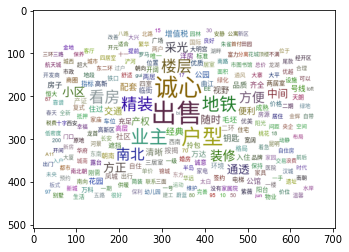

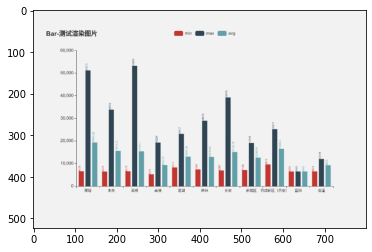

In [20]:
%matplotlib inline
import matplotlib.pyplot as plt
from PIL import Image
import cv2
pic1 = cv2.imread('1.png')
# Image.open('1.png').convert('RGB')
plt.imshow(pic1)
plt.show()
pic2 = Image.open('2.png').convert('RGB')
plt.imshow(pic2)
plt.show()